In [3]:
import os
import re
import time
import pickle
import asyncio
import nest_asyncio
import pandas as pd
import json
import logging
from tqdm import tqdm
from collections import defaultdict
from IPython.display import clear_output
from typing import List, Dict, Any

from dotenv import load_dotenv
from langchain.docstore.document import Document
from langchain.chains import RetrievalQA, LLMChain
from langchain.prompts import PromptTemplate
from langchain_community.embeddings import ClovaXEmbeddings
from langchain_community.chat_models import ChatClovaX
from pymilvus import connections, utility
from langchain_community.vectorstores.milvus import Milvus
from langchain.schema import BaseRetriever
from sklearn.metrics.pairwise import cosine_similarity
from pydantic import BaseModel, Field  # Field 추가

In [4]:
# 로깅 설정
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

In [5]:
# ---------------------- Custom Retriever ----------------------
# 리팩토링된 ISBNMergingRetriever 클래스 정의 (기존 코드 유지)
class ISBNMergingRetriever(BaseRetriever):
    base_retriever: BaseRetriever

    def _get_relevant_documents(self, query: str) -> List[Document]:
        docs = self.base_retriever.get_relevant_documents(query)
        grouped, merged_docs = {}, []
        for doc in docs:
            isbn = doc.metadata.get("ISBN", "NO_ISBN")
            if isbn == "NO_ISBN":
                # ISBN 없는 문서는 그대로 유지하거나, 필터링할 수 있음 (여기서는 유지 안 함)
                continue
            grouped.setdefault(isbn, []).append(doc)
        for isbn, doc_list in grouped.items():
            # 동일 ISBN 문서 병합
            combined_text = "\n".join(d.page_content for d in doc_list)
            # 메타데이터는 첫 번째 문서 것을 사용 (필요 시 병합 로직 추가 가능)
            merged_meta = dict(doc_list[0].metadata)
            # 디버그 로그 강화
            logger.debug(
                f"[ISBN Merging] ISBN: {isbn}, Merged Chunks: {len(doc_list)}, Combined Text Length: {len(combined_text)}"
            )
            merged_docs.append(
                Document(page_content=combined_text, metadata=merged_meta)
            )
        # 만약 그룹화되지 않은 문서(ISBN 없는 문서)도 포함하고 싶다면 아래 주석 해제
        # non_grouped_docs = [doc for doc in docs if doc.metadata.get("ISBN", "NO_ISBN") == "NO_ISBN"]
        # merged_docs.extend(non_grouped_docs)
        logger.info(
            f"ISBN 기준으로 {len(grouped)} 그룹 병합 완료. 최종 문서 수: {len(merged_docs)}"
        )
        return merged_docs

    async def _aget_relevant_documents(self, query: str) -> List[Document]:
        # 비동기 버전도 동기 버전과 동일한 로직 적용
        docs = await self.base_retriever.aget_relevant_documents(query)
        grouped, merged_docs = {}, []
        for doc in docs:
            isbn = doc.metadata.get("ISBN", "NO_ISBN")
            if isbn == "NO_ISBN":
                continue
            grouped.setdefault(isbn, []).append(doc)
        for isbn, doc_list in grouped.items():
            combined_text = "\n".join(d.page_content for d in doc_list)
            merged_meta = dict(doc_list[0].metadata)
            logger.debug(
                f"[Async ISBN Merging] ISBN: {isbn}, Merged Chunks: {len(doc_list)}, Combined Text Length: {len(combined_text)}"
            )
            merged_docs.append(
                Document(page_content=combined_text, metadata=merged_meta)
            )
        logger.info(
            f"Async ISBN 기준으로 {len(grouped)} 그룹 병합 완료. 최종 문서 수: {len(merged_docs)}"
        )
        return merged_docs

    def add_documents(self, documents: List[Document], **kwargs) -> None:
        # 이 리트리버는 문서를 직접 추가하는 기능은 없음 (Base Retriever가 담당)
        pass

    def get_type(self) -> str:  # Pydantic v1 호환성을 위해 추가
        return "isbn_merging_retriever"

In [6]:
# text는 아래와 같은 형태로 들어가서 청크

# 제목 : [값]
# 분류 : [값]
# 저자 : [값]
# 저자소개 : [값]
# 책 소개 : [값]
# 목차 : [값]
# 출판사리뷰 : [값]

# 임베딩 pkl에 포함된 메타데이터 컬럼과 (임베딩,원본text)로 묶인 컬럼

# metadata_columns = ['ISBN', '페이지', '가격', '제목', '저자']
# vector_doc_columns = ['제목', '분류', '저자','저자소개', '책소개', '목차', '출판사리뷰','추천사']

In [7]:
# ---------------------- Helper Functions ----------------------
def is_similar_question(new_emb, prev_embeds, threshold=0.65):
    if not prev_embeds:
        return False
    sim_scores = cosine_similarity([new_emb], prev_embeds)[0]
    max_score = max(sim_scores)
    logger.info(f"[중복 유사도 판단] Max = {max_score:.3f}")
    return max_score > threshold


def extract_field(text, field_name):
    # 정규식 수정: 필드 이름 뒤 공백 허용, 값 시작 부분의 공백 제거
    pattern = rf"^\s*{re.escape(field_name)}\s*:\s*(.*?)\s*$"
    lines = text.splitlines()
    for line in lines:
        match = re.search(pattern, line, re.IGNORECASE)  # 대소문자 무시
        if match:
            return match.group(1).strip()
    return ""  # 매칭되는 필드가 없으면 빈 문자열 반환

In [8]:
# ---------------------- Helper Functions ----------------------
def is_similar_question(new_emb, prev_embeds, threshold=0.65):
    if not prev_embeds:
        return False
    sim_scores = cosine_similarity([new_emb], prev_embeds)[0]
    max_score = max(sim_scores)
    print(f"[중복 유사도 판단] Max = {max_score:.3f}")
    return max_score > threshold


def extract_field(text, field_name):
    pattern = rf"{re.escape(field_name)}\s*:\s*(.*)"
    match = re.search(pattern, text)
    return match.group(1).strip() if match else ""

In [9]:
# ---------------------- 환경설정 및 임베딩 ----------------------
load_dotenv(dotenv_path=r"C:\Kill_the_RAG\Project\Aiffel_final_project\.env")

# API 키 환경 변수 설정 확인
api_key = os.getenv("NCP_CLOVASTUDIO_API_KEY")
api_url = os.getenv("NCP_CLOVASTUDIO_API_URL", "https://clovastudio.stream.ntruss.com/")
milvus_host = os.getenv("MILVUS_HOST", "localhost")
milvus_port = os.getenv("MILVUS_PORT", "19530")

if not api_key:
    raise ValueError("NCP_CLOVASTUDIO_API_KEY 환경 변수가 설정되지 않았습니다.")
if not api_url:
    raise ValueError("NCP_CLOVASTUDIO_API_URL 환경 변수가 설정되지 않았습니다.")

os.environ["NCP_CLOVASTUDIO_API_KEY"] = api_key
os.environ["NCP_CLOVASTUDIO_API_URL"] = api_url

# Milvus 연결 설정
# try:
#     connections.connect(
#         alias="default",
#         host=milvus_host,
#         port=milvus_port,
#     )
#     logger.info(f"Milvus 연결 성공: host={milvus_host}, port={milvus_port}")
# except Exception as e:
#     logger.error(f"Milvus 연결 실패: {e}")
#     raise

logger.info(
    "Milvus 전역 연결 설정 건너뛰고, Langchain Milvus 인스턴스가 직접 관리하도록 설정합니다."
)

# 모델 초기화
try:
    ncp_embeddings = ClovaXEmbeddings(model="bge-m3")
    llm_clova = ChatClovaX(model="HCX-003", max_tokens=2048)  # max_tokens 조정 가능
    logger.info("ClovaX Embeddings 및 Chat 모델 초기화 완료")
except Exception as e:
    logger.error(f"ClovaX 모델 초기화 실패: {e}")
    raise

# 임베딩 데이터 로드
embedding_file = r"C:\Kill_the_RAG\Project\Aiffel_final_project\Code\Data\semifinal_embedding\embedding_semifinal.pkl"  # 실제 경로로 수정하세요
if os.path.exists(embedding_file):
    try:
        with open(embedding_file, "rb") as f:
            saved_data = pickle.load(f)
        all_text_embedding_pairs = saved_data[
            "embeddings"
        ]  # (text, embedding) 쌍 리스트
        all_metadata_list = saved_data["metadata"]  # 메타데이터 딕셔너리 리스트
        logger.info(f"임베딩 데이터 로드 완료: {len(all_text_embedding_pairs)}개")
    except Exception as e:
        logger.error(f"임베딩 파일 로드 실패: {e}")
        raise
else:
    raise FileNotFoundError(f"임베딩 파일을 찾을 수 없습니다: {embedding_file}")

# 메타데이터 키 매핑 (필요에 따라 수정)
metadata_mapping = {
    "ISBN": "ISBN",
    "페이지": "page",
    "가격": "price",
    "제목": "title",
    "저자": "author",
    "분류": "category",
    "저자소개": "author_intro",
    "책소개": "book_intro",
    "목차": "table_of_contents",
    "출판사리뷰": "publisher_review",
    "추천사": "recommendation",
}

# 메타데이터 키 표준화 및 Document 객체 생성
documents = []
for pair, meta in zip(all_text_embedding_pairs, all_metadata_list):
    # pair[0]: text, pair[1]: embedding
    # meta: original metadata dict
    standardized_meta = {metadata_mapping.get(k, k): v for k, v in meta.items()}
    # Document 객체 생성 시 메타데이터 포함
    documents.append(Document(page_content=pair[0], metadata=standardized_meta))

logger.info(f"총 {len(documents)}개의 Document 객체 생성 완료.")

# Milvus 컬렉션 설정 및 데이터 추가
collection_name = "book_rag_db"  # 컬렉션 이름
temp_conn_alias = "utility_check_conn"  # 충돌 방지를 위해 다른 alias 사용 가능 (선택 사항, default도 무방)
try:
    # 유틸리티 함수 사용 전에 임시로 연결 설정
    connections.connect(alias=temp_conn_alias, host=milvus_host, port=milvus_port)
    logger.info(
        f"Milvus 유틸리티 함수용 임시 연결 설정 완료 (alias: {temp_conn_alias})."
    )

    # utility 함수 호출 시 'using' 파라미터로 해당 alias 지정
    if utility.has_collection(collection_name, using=temp_conn_alias):
        logger.warning(
            f"기존 컬렉션 '{collection_name}'을 삭제합니다 (using: {temp_conn_alias})."
        )
        utility.drop_collection(collection_name, using=temp_conn_alias)
    else:
        logger.info(f"컬렉션 '{collection_name}'이(가) 존재하지 않습니다.")

except Exception as e:
    logger.error(f"Milvus 유틸리티 함수 실행 중 오류 발생: {e}", exc_info=True)
    # 오류 발생 시에도 연결 해제 시도 후 종료
    try:
        connections.disconnect(temp_conn_alias)
        logger.info(f"오류 발생 후 Milvus 임시 연결 해제됨 (alias: {temp_conn_alias}).")
    except Exception as disconnect_e:
        logger.error(f"Milvus 임시 연결 해제 중 오류: {disconnect_e}")
    raise  # 원래 오류를 다시 발생시켜 문제 인지
finally:
    # 정상 실행 시에도 연결 해제 (finally 블록에서 확실히 해제)
    try:
        if connections.has_connection(
            temp_conn_alias
        ):  # 연결이 실제로 있는지 확인 후 해제
            connections.disconnect(temp_conn_alias)
            logger.info(
                f"Milvus 유틸리티 함수용 임시 연결 해제 완료 (alias: {temp_conn_alias})."
            )
    except Exception as disconnect_e:
        # 연결 설정 자체가 실패했을 수 있으므로 해제 오류는 경고로 처리 가능
        logger.warning(f"Milvus 임시 연결 해제 중 오류 (무시 가능): {disconnect_e}")

try:
    vectorstore = Milvus(
        embedding_function=ncp_embeddings,
        collection_name=collection_name,
        connection_args={"host": milvus_host, "port": milvus_port},
        auto_id=True,  # 자동 ID 사용
    )
    logger.info(
        f"Langchain Milvus 인스턴스 초기화 및 연결 설정 완료 (컬렉션: '{collection_name}')."
    )

    # 사전 계산된 임베딩 사용
    texts = [doc.page_content for doc in documents]
    embeds = [pair[1] for pair in all_text_embedding_pairs]  # 임베딩만 추출
    metadatas = [doc.metadata for doc in documents]

    # 임베딩 함수 오버라이드 (사전 계산된 임베딩 사용 위함)
    original_embed_documents = ClovaXEmbeddings.embed_documents

    def precomputed_embed_documents(cls, input_texts):
        # 입력 텍스트 순서가 texts와 동일하다고 가정 (매우 중요)
        if len(input_texts) != len(texts) or input_texts != texts:
            logger.warning(
                "입력 텍스트가 사전 계산된 텍스트와 다릅니다. 순서/내용 확인 필요."
            )
            # 실제 운영 시에는 여기서 에러를 발생시키거나, 새로 임베딩해야 할 수 있음
            # 여기서는 일단 경고만 하고 진행
        return embeds

    ClovaXEmbeddings.embed_documents = classmethod(precomputed_embed_documents)

    vectorstore.add_texts(
        texts=texts, metadatas=metadatas, embeddings=embeds
    )  # embeddings 인자 전달
    logger.info(f"Milvus에 {len(texts)}개의 텍스트와 임베딩 추가 완료.")

    # 임베딩 함수 원복
    ClovaXEmbeddings.embed_documents = original_embed_documents

except Exception as e:
    logger.error(f"Milvus 데이터 추가 중 오류 발생: {e}")
    # 임베딩 함수 원복 (오류 발생 시에도)
    if "original_embed_documents" in locals():
        ClovaXEmbeddings.embed_documents = original_embed_documents
    raise

2025-04-02 20:38:47,027 - INFO - Milvus 전역 연결 설정 건너뛰고, Langchain Milvus 인스턴스가 직접 관리하도록 설정합니다.
2025-04-02 20:38:47,963 - INFO - ClovaX Embeddings 및 Chat 모델 초기화 완료
2025-04-02 20:39:00,726 - INFO - 임베딩 데이터 로드 완료: 99845개
2025-04-02 20:39:02,699 - INFO - 총 99845개의 Document 객체 생성 완료.
2025-04-02 20:39:03,188 - INFO - Milvus 유틸리티 함수용 임시 연결 설정 완료 (alias: utility_check_conn).
2025-04-02 20:39:03,207 - WARNING - 기존 컬렉션 'book_rag_db'을 삭제합니다 (using: utility_check_conn).
2025-04-02 20:39:03,336 - INFO - Milvus 유틸리티 함수용 임시 연결 해제 완료 (alias: utility_check_conn).
C:\Users\computer\AppData\Local\Temp\ipykernel_32100\3339307333.py:129: LangChainDeprecationWarning: The class `Milvus` was deprecated in LangChain 0.2.0 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-milvus package and should be used instead. To use it run `pip install -U :class:`~langchain-milvus` and import as `from :class:`~langchain_milvus import MilvusVectorStore``.
  vectorstore = Milvus(
202

In [10]:
# ---------------------- Retriever 및 QA 체인 ----------------------
# 기본 Dense Retriever 설정 (Vector Store 사용)
dense_retriever = vectorstore.as_retriever(
    search_kwargs={"k": 5}
)  # 검색 결과 수 조정 (기존 3 -> 5)

# ISBN 기준으로 병합하는 Retriever 설정
merged_retriever = ISBNMergingRetriever(base_retriever=dense_retriever)

# RetrievalQA 체인 설정 (병합된 Retriever 사용)
dpr_qa_chain = RetrievalQA.from_chain_type(
    llm=llm_clova,
    retriever=merged_retriever,
    return_source_documents=True,  # 소스 문서 반환 활성화
)

MIN_INFO_LENGTH = 10  # 정보 길이 최소값

# 전역 변수
previous_additional_question_embeddings = []

In [ ]:
# ---------------------- 프롬프트 템플릿 ----------------------
# 1. 사용자 선호도 추출 프롬프트 (수정됨)
extract_pref_prompt_v2 = PromptTemplate(
    input_variables=["text"],
    # 오류 수정: JSON 구조를 {{ }} 로 감싸지 않고 문자열 리터럴로 처리
    template="""
다음 사용자 발화에서 사용자의 선호도 및 책에 대한 요구사항을 아래 JSON 형식으로 추출해라. 각 항목은 관련된 정보가 있을 때만 포함하고, 없다면 빈 리스트 `[]` 또는 빈 문자열 `""`로 남겨라. 여러개가 추출될 수 있는 항목은 리스트로 추출하라.

입력: {{ text }}

출력 형식 (JSON, 다른 설명 없이 JSON만 출력):
{
    "title": [<!-- 추출된 관련 제목 목록 -->],
    "author": [<!-- 추출된 관련 저자 목록 -->],
    "category": [<!-- 추출된 관련 카테고리/장르 목록 -->],
    "author_intro": [<!-- 저자 소개 관련 언급/요구사항 목록 -->],
    "book_intro": [<!-- 책 소개/줄거리 관련 언급/요구사항 목록 -->],
    "table_of_contents": [<!-- 목차 관련 언급/요구사항 목록 -->],
    "purpose": [<!-- 사용자의 독서 목적/이유 목록 (예: '재미', '학습', '시간 때우기', '기분') -->],
    "implicit info": [<!-- 추천해야 할 책에 대한 암시적 정보/특징/분위기 목록 (예: '밝은 분위기', '특정 상황에 어울리는 책', '최신 기술 동향') -->]
}
""",
    template_format="jinja2",  # 'text' 변수 치환을 위해 jinja2 유지
)

# 2. 선호도 통합 프롬프트
consolidate_pref_prompt = PromptTemplate(
    input_variables=["existing_preferences", "new_preferences"],
    template="""
기존에 수집된 사용자 선호도 정보와 새로 추출된 선호도 정보가 주어졌다. 두 정보를 지능적으로 통합하여 중복을 제거하고 관련 내용을 요약/결합하여 최종 선호도 목록을 생성해라.

[기존 선호도]
{{ existing_preferences }}

[새로운 선호도]
{{ new_preferences }}

[통합된 최종 선호도 목록]
(아래 목록 형태로만 출력, 각 항목은 문자열 리스트)
- 항목1: ["통합 내용1", "통합 내용2"]
- 항목2: ["통합 내용3"]
...
""",
    template_format="jinja2",
)


# 3. Decision Prompt (기존 유지, 약간 수정하여 명확성 증대)
decision_prompt_template = PromptTemplate(
    template="""
[대화 맥락]
사용자 대화 내역:
{{ history }}
사용자의 최신 질문: "{{ query }}"
수집된 사용자 선호도:
{{ preferences }}

[역할 및 목표]
{{ role_instructions }}
현재 대화 상황, 질문, 수집된 선호도를 분석하여 아래 두 가지 행동 중 하나만 결정하고 필요한 정보를 생성하라.
- "추천": 사용자가 명시적으로 추천을 요청했거나, 사용자의 선호도 정보(카테고리, 저자, 목적, 분위기 등)를 **구체적으로 4개 이상** 알 때.
- "추가 질문": 추천하기에 정보가 부족하거나 모호할 때, **아직 수집되지 않았거나 더욱 구체적인 선호도 정보**를 얻기 위한 질문 생성. (예: 어떤 장르를 선호하시나요? 특정 작가를 찾으시나요? 책을 읽는 목적이 무엇인가요?)

[출력 형식] (반드시 아래 형식만 정확히 따를 것)
행동: <추천 또는 추가 질문>
추가 질문: <"추가 질문" 행동일 경우 구체적인 질문 생성, "추천" 행동일 경우 빈 문자열>
""",
    input_variables=["history", "query", "preferences", "role_instructions"],
    template_format="jinja2",
)

# 4. Final Query Generation Prompt (기존 유지)
final_query_generation_template = PromptTemplate(
    template="""
[대화 요약]
{{ history }}

[사용자 요청]
{{ query }}

[페르소나 정보]
{{ persona_info }}

[사용자 선호도 요약]
{{ preferences }}

위 정보를 전부 활용하여, 도서 검색에 가장 유용한 **핵심 키워드 중심의 최종 검색 쿼리**를 한 문장으로 작성하라.
오직 검색 쿼리 문장만 출력하라.
""",
    input_variables=["history", "query", "persona_info", "preferences"],
    template_format="jinja2",
)

# 5. Refine Prompt (기존 유지)
refine_prompt = PromptTemplate(
    input_variables=["query"],
    template="""주어진 검색 쿼리를 분석하여, 검색 엔진이나 다음 단계에서 사용하기 좋은 명확하고 간결한 단일 문장으로 정제해라. 불필요한 설명 없이 오직 정제된 쿼리 문장만 출력해라.

[원본 검색 쿼리]
{{ query }}

[정제된 검색 쿼리]
""",
    template_format="jinja2",
)

# 6. Query Expansion Prompt (기존 유지, 예시 강화)
query_expansion_prompt = PromptTemplate(
    input_variables=["query"],
    template="""주어진 원본 검색 쿼리를 바탕으로, 관련성이 높으면서도 다양한 측면을 탐색할 수 있는 확장된 검색 쿼리 3개를 생성해라. 확장된 쿼리는 원본 쿼리의 핵심 의도를 반드시 유지해야 한다. 다른 설명이나 서론 없이, 오직 번호(1., 2., 3.)가 매겨진 확장 쿼리 목록만 한 줄에 하나씩 출력해라.

- "~~비슷한", "~ 같은", "~ 분위기의" 라고 사용자가 언급하면, 해당 책/저자의 **특징(예: 장르, 분위기, 핵심 소재, 작가 스타일)**을 반영하여 확장하라. 책 제목이나 저자 이름을 직접 포함하지 마라.
- 예시 (입력: 해리포터 시리즈물같은 판타지 소설 알려줘) ->
1. 마법학교 배경의 청소년 판타지 소설 추천
2. 선과 악의 대결을 다룬 영국 판타지 시리즈
3. 성장 서사를 담은 인기 판타지 소설

[원본 검색 쿼리]
{{ query }}

[확장된 검색 쿼리 목록]
""",
    template_format="jinja2",
)

# 7. Re-ranking Prompt (기존 유지, 입력 변수 명시)
re_ranking_prompt = PromptTemplate(
    input_variables=["query", "documents"],
    template="""사용자의 검색 쿼리는 다음과 같습니다: "{{ query }}"
다음은 검색된 도서 목록입니다 (내용은 일부만 표시됨):
{% for doc in documents %}
{{ loop.index }}. 제목: {{ doc.metadata.get('title', '제목 없음') }}, 저자: {{ doc.metadata.get('author', '저자 없음') }}, 내용 일부: {{ doc.page_content | truncate(200) }}
{% endfor %}

위 검색 결과를 사용자의 검색 쿼리 "{{ query }}"와의 관련성, 그리고 문서 내용의 충실도를 종합적으로 고려하여 가장 적합한 순서대로 재배치하라.
가장 관련성이 높은 도서를 목록의 맨 위에 배치하고, 순위가 매겨진 **도서 제목과 저자**만으로 결과를 다음 형식으로 출력하라.

[출력 형식 예시]
1. 제목: <가장 관련성 높은 책 제목>, 저자: <저자 이름>
2. 제목: <두 번째 관련성 높은 책 제목>, 저자: <저자 이름>
...

[리랭킹된 도서 목록]
""",
    template_format="jinja2",
)

# 8. HyDE Generation Prompt (신규)
hyde_generation_prompt = PromptTemplate(
    input_variables=["query"],
    template="""다음 검색 쿼리에 완벽하게 부합하는 **이상적인 가상의 책**에 대한 **간결한 요약(1-2 문장)**을 생성해라. 이 요약은 해당 쿼리로 책을 찾는 사용자가 가장 만족할 만한 내용을 담고 있어야 한다. 오직 생성된 요약 텍스트만 출력하라.

[검색 쿼리]
{{ query }}

[가상의 책 요약]
""",
    template_format="jinja2",
)


# ---------------------- 페르소나별 Role (기존 유지) ----------------------
literature_role = "너는 감성적이고 문학적인 도서 추천 챗봇이다. 사용자의 감정과 취향을 깊이 이해하고 공감하며, 문학적인 표현을 사용하여 책을 추천해라."
science_role = "너는 정확하고 논리적인 과학/기술 도서 추천 챗봇이다. 사용자의 지식 수준과 관심 분야를 파악하고, 최신 정보와 기술 동향을 반영하여 체계적으로 책을 추천해라."
general_role = "너는 친절하고 신뢰할 수 있는 범용 도서 추천 챗봇이다. 다양한 분야의 책에 대해 균형 잡힌 시각으로 정보를 제공하고, 사용자의 요구사항에 맞춰 명확하고 이해하기 쉽게 책을 추천해라."

In [12]:
# ---------------------- Async Invoke 함수 (개선) ----------------------
async def async_invoke(chain: LLMChain, vars_dict: dict, step_name: str) -> dict:
    """LLMChain을 비동기적으로 호출하고 결과를 반환합니다."""
    try:
        # 입력 변수 로깅 시 민감 정보 주의 (필요 시 마스킹)
        logger.debug(
            f"[{step_name}] Chain 호출 시작. 입력 변수 일부: { {k: v[:100] + '...' if isinstance(v, str) and len(v) > 100 else v for k, v in vars_dict.items()} }"
        )
        # asyncio.to_thread 사용으로 동기 함수를 비동기 이벤트 루프에서 실행
        result = await asyncio.to_thread(chain.invoke, vars_dict)
        # 결과 로깅 시 길이 제한
        result_text = result.get("text", "")
        logger.debug(
            f"[{step_name}] Chain 호출 완료. 결과 일부: {result_text[:200] + '...' if len(result_text) > 200 else result_text}"
        )
        return result
    except Exception as e:
        logger.error(
            f"[{step_name}] Chain 호출 중 예외 발생: {e}", exc_info=True
        )  # exc_info=True로 트레이스백 로깅
        return {"text": ""}  # 오류 발생 시 빈 텍스트 반환


async def async_invoke_llm(prompt: str, step_name: str) -> str:
    """LLM을 직접 비동기적으로 호출하고 텍스트 결과를 반환합니다."""
    try:
        logger.debug(
            f"[{step_name}] LLM 호출 시작. 프롬프트 일부: {prompt[:200] + '...' if len(prompt) > 200 else prompt}"
        )
        response = await asyncio.to_thread(llm_clova.invoke, prompt)
        # response 객체 타입 확인 및 텍스트 추출 (API 응답 형식에 따라 다를 수 있음)
        if hasattr(response, "content"):  # Langchain v0.1.0 이후 AIMessage 형식
            result_text = response.content.strip()
        elif hasattr(response, "text"):  # 이전 버전 또는 다른 응답 형식
            result_text = response.text().strip()
        else:  # 직접 문자열 반환하는 경우
            result_text = str(response).strip()

        logger.debug(
            f"[{step_name}] LLM 호출 완료. 응답 일부: {result_text[:200] + '...' if len(result_text) > 200 else result_text}"
        )
        return result_text
    except Exception as e:
        logger.error(f"[{step_name}] LLM 호출 중 예외 발생: {e}", exc_info=True)
        return ""  # 오류 발생 시 빈 문자열 반환

In [13]:
# ---------------------- 검색 필터 Weighting 함수 (기존 유지) ----------------------
def weighted_sort(
    docs: List[Document], preferences: Dict[str, List[str]]
) -> List[Document]:
    """선호도에 따라 문서 점수를 매겨 정렬합니다."""

    def score(doc):
        s = 0.0
        # 가중치 조절 가능
        author_pref = preferences.get("author", [])
        if author_pref and doc.metadata.get("author") in author_pref:
            s += 0.3  # 저자 일치 시 높은 가중치
        category_pref = preferences.get("category", [])
        if category_pref and doc.metadata.get("category") in category_pref:
            s += 0.2  # 카테고리 일치 시 가중치

        # implicit info도 점수화 시도 (키워드 매칭 등)
        implicit_pref = preferences.get("implicit info", [])
        if implicit_pref:
            content_lower = doc.page_content.lower()
            for keyword in implicit_pref:
                if keyword.lower() in content_lower:
                    s += 0.1  # 암시적 정보 키워드 포함 시 약간의 가중치
        return s

    # 점수가 높은 순으로 정렬, 점수가 같으면 원래 순서 유지 (stable sort)
    return sorted(docs, key=score, reverse=True)

In [14]:
# ---------------------- Async Invoke 함수 ----------------------
async def async_invoke(chain: LLMChain, vars_dict: dict, step_name: str) -> dict:
    try:
        print(f"\n[디버그] {step_name} 호출 전 변수: {vars_dict}")
        result = await asyncio.to_thread(chain.invoke, vars_dict)
        print(f"\n[디버그] {step_name} 결과: {result}")
        return result
    except Exception as e:
        print(f"[에러] {step_name}에서 예외 발생: {str(e)}")
        return {"text": ""}


async def async_invoke_llm(prompt: str, step_name: str) -> str:
    try:
        print(f"\n[디버그] {step_name} 프롬프트 호출:\n{prompt}")
        response = await asyncio.to_thread(llm_clova.invoke, prompt)
        result_text = response.text().strip()
        print(f"\n[디버그] {step_name} 응답: {result_text}")
        return result_text
    except Exception as e:
        print(f"[에러] {step_name}에서 예외 발생: {str(e)}")
        return ""

In [ ]:
# ---------------------- Base RAG Pipeline (대폭 수정) ----------------------
class BaseRAGPipeline:
    def __init__(
        self, config, llm, embeddings, vectorstore, retriever, qa_chain, documents
    ):
        self.config = config
        self.llm = llm
        self.embeddings = embeddings  # 임베딩 모델 추가
        self.vectorstore = vectorstore  # Vectorstore 직접 접근 위해 추가
        self.retriever = retriever  # ISBN Merging Retriever
        self.qa_chain = qa_chain  # 기본 QA 체인 (사용 빈도 줄어들 수 있음)
        self.documents = documents  # 전체 문서 목록 (메타데이터 접근용)

        # 대화 기록 및 상태 변수
        self.user_history: List[str] = []
        self.llm_history: List[str] = []
        # 사용자 선호도 구조 변경 (JSON 스키마 반영)
        self.user_preferences: Dict[str, List[str]] = {
            "title": [],
            "author": [],
            "category": [],
            "author_intro": [],
            "book_intro": [],
            "table_of_contents": [],
            "purpose": [],
            "implicit info": [],
        }
        self.preferences_text: str = ""  # 선호도 요약 텍스트 (LLM 입력용)
        self.preference_update_count: int = 0

        self.last_recommendations: List[Document] = []
        self.last_action: str | None = (
            None  # 마지막 챗봇 행동 ("추천" 또는 "추가 질문")
        )

        # LLM Chain 초기화
        self.extract_pref_chain = LLMChain(llm=self.llm, prompt=extract_pref_prompt_v2)
        # self.consolidate_pref_chain = LLMChain(llm=self.llm, prompt=consolidate_pref_prompt) # LLM 통합은 일단 보류
        self.decision_chain = LLMChain(llm=self.llm, prompt=decision_prompt_template)
        self.final_query_generation_chain = LLMChain(
            llm=self.llm, prompt=final_query_generation_template
        )
        self.refine_chain = LLMChain(
            llm=self.llm, prompt=refine_prompt
        )  # refine chain 추가
        self.query_expansion_chain = LLMChain(
            llm=self.llm, prompt=query_expansion_prompt
        )
        self.re_ranking_chain = LLMChain(llm=self.llm, prompt=re_ranking_prompt)
        self.hyde_generation_chain = LLMChain(
            llm=self.llm, prompt=hyde_generation_prompt
        )  # 신규

    def robust_parse_decision_response(
        self, response_text: str
    ) -> tuple[str | None, str]:
        """LLM의 행동 결정 응답을 파싱합니다."""
        action_match = re.search(r'행동\s*[:：]\s*"?([^"\n]+)"?', response_text)
        action = action_match.group(1).strip() if action_match else None

        follow_match = re.search(r'추가\s*질문\s*[:：]\s*"?([^"\n]+)"?', response_text)
        additional_question = follow_match.group(1).strip() if follow_match else ""

        if not action:
            logger.warning(
                f"행동 결정 파싱 실패: '{response_text}'. 기본 '추가 질문'으로 처리."
            )
            # 파싱 실패 시 안전하게 추가 질문 유도 또는 추천 시도 결정 필요
            # 여기서는 일단 추가 질문으로 처리
            return "추가 질문", additional_question

        logger.info(
            f"행동 결정 파싱 결과: 행동='{action}', 추가 질문='{additional_question}'"
        )
        return action, additional_question

    async def update_preferences_from_input(self, user_input: str) -> None:
        """
        사용자 입력에서 선호도를 추출하고 기존 선호도와 통합합니다.
        """
        logger.info(f"사용자 입력에서 선호도 추출 시작: '{user_input[:100]}...'")

        # 1. LLM을 사용하여 선호도 추출
        extract_result = await async_invoke(
            self.extract_pref_chain, {"text": user_input}, "선호도 추출"
        )
        extracted_text = extract_result.get("text", "{}")

        try:
            # LLM 응답에서 JSON 부분만 정확히 추출 시도
            json_match = re.search(r"\{.*\}", extracted_text, re.DOTALL)
            if json_match:
                extracted_prefs_raw = json.loads(json_match.group(0))
            else:
                logger.warning(
                    f"선호도 추출 결과에서 JSON 객체를 찾을 수 없음: {extracted_text}"
                )
                extracted_prefs_raw = {}

            # 값들이 리스트 형태인지 확인 및 변환, 정의된 키만 사용
            extracted_prefs: Dict[str, List[str]] = {}
            defined_keys = self.user_preferences.keys()
            for key, value in extracted_prefs_raw.items():
                if key in defined_keys:
                    if isinstance(value, list):
                        extracted_prefs[key] = [
                            str(item) for item in value if item
                        ]  # 빈 항목 제거 및 문자열화
                    elif isinstance(value, str) and value:
                        extracted_prefs[key] = [value]
                    # 다른 타입(숫자 등)이 올 경우 문자열로 변환하여 리스트에 추가할 수도 있음
                    # elif value is not None:
                    #    extracted_prefs[key] = [str(value)]
                    else:  # None 이거나 빈 값은 무시 (또는 빈 리스트로 넣을 수도 있음)
                        pass
                        # extracted_prefs[key] = []
                else:
                    logger.warning(
                        f"추출된 선호도 키 '{key}'가 정의된 스키마에 없습니다. 무시합니다."
                    )

            logger.info(
                f"추출 및 정제된 선호도: {json.dumps(extracted_prefs, ensure_ascii=False)}"
            )

        except json.JSONDecodeError as e:
            logger.error(
                f"선호도 추출 결과 JSON 파싱 실패: {e}. 원본 텍스트: {extracted_text}"
            )
            extracted_prefs = {}  # 파싱 실패 시 빈 객체

        if not extracted_prefs:
            logger.info("새로 추출된 유효한 선호도 정보가 없습니다.")
        else:
            # 2. 기존 선호도와 통합 (간단한 병합 및 중복 제거)
            updated_something = False
            for key, new_values in extracted_prefs.items():
                if new_values:  # 새로운 값이 있을 때만
                    existing_values_set = set(self.user_preferences.get(key, []))
                    new_values_set = set(new_values)
                    # 새로운 값만 추가 (기존 값은 유지)
                    added_values = new_values_set - existing_values_set
                    if added_values:
                        self.user_preferences[key].extend(list(added_values))
                        self.user_preferences[key] = sorted(
                            list(set(self.user_preferences[key]))
                        )  # 최종 정렬 및 중복제거
                        updated_something = True
                        logger.info(
                            f"선호도 업데이트됨 [{key}]: {self.user_preferences[key]}"
                        )

            if updated_something:
                self.preference_update_count += 1
                logger.info(
                    f"선호도 업데이트 완료. 누적 업데이트 횟수: {self.preference_update_count}"
                )
            else:
                logger.info("기존 선호도에서 변경된 내용 없음.")

        # 3. 선호도 요약 텍스트 업데이트 (LLM 입력용)
        pref_items = []
        for key, values in self.user_preferences.items():
            if values:  # 값이 있는 항목만 포함
                # 키 이름을 좀 더 자연스러운 한국어로 변경 (선택 사항)
                display_key = {
                    "title": "관련 제목",
                    "author": "관련 저자",
                    "category": "선호 장르/분류",
                    "author_intro": "저자 관련 요구",
                    "book_intro": "내용 관련 요구",
                    "table_of_contents": "목차 관련 요구",
                    "purpose": "독서 목적",
                    "implicit info": "책에 대한 암시적 요구",
                }.get(key, key)
                pref_items.append(f"- {display_key}: {', '.join(values)}")
        self.preferences_text = (
            "\n".join(pref_items) if pref_items else "수집된 선호도 없음"
        )
        logger.debug(f"업데이트된 선호도 요약 텍스트:\n{self.preferences_text}")

    async def get_final_query(self, current_user_query: str) -> str:
        """
        대화 기록, 사용자 쿼리, 페르소나 정보, 통합된 선호도를 바탕으로 최종 검색 쿼리를 생성하고 정제.
        """
        logger.info("최종 검색 쿼리 생성 시작")

        # 페르소나 정보 설정
        persona = self.config.get("persona")
        if persona == "Literature":
            persona_info = "감성, 현재 기분, 선호하는 문학 장르 및 작가 정보"
        elif persona == "Science":
            persona_info = "초심자 여부, 관심 분야, 구체적인 기술 정보"
        else:  # General 또는 기타
            persona_info = "장르, 책을 찾는 이유, 독서 취향 정보"

        # LLM에 전달할 변수 준비
        final_query_vars = {
            "history": "\n".join(self.user_history[-5:]),  # 최근 5개 대화 이력
            "query": current_user_query,  # 현재 사용자 질문 원본
            "persona_info": persona_info,
            "preferences": self.preferences_text,  # 통합된 선호도 요약 텍스트
        }

        # Step 1: 최종 쿼리 생성 (선호도 종합)
        result_gen = await async_invoke(
            self.final_query_generation_chain, final_query_vars, "선호도 종합 쿼리 생성"
        )
        generated_query = result_gen.get("text", "").strip()
        logger.info(f"LLM 생성 쿼리 (정제 전): '{generated_query}'")

        # Step 2: 생성된 쿼리 정제 (Refine)
        query_to_use = ""
        if generated_query:
            refine_result = await async_invoke(
                self.refine_chain, {"query": generated_query}, "쿼리 정제"
            )
            refined_query = (
                refine_result.get("text", "").strip().strip('"')
            )  # 따옴표 제거
            logger.info(f"정제된 쿼리: '{refined_query}'")

            # 정제 결과 유효성 검사 (너무 짧거나, 원본과 같거나, 부정적인 답변 등)
            negative_keywords = [
                "없",
                "못",
                "않",
                "오류",
                "잘못",
                "알 수 없",
                "쿼리",
                "입력",
                "죄송",
            ]
            is_invalid_refinement = (
                not refined_query
                or len(refined_query) < 5
                or refined_query == generated_query
                or any(keyword in refined_query for keyword in negative_keywords)
            )

            if is_invalid_refinement:
                logger.warning(
                    f"정제된 쿼리('{refined_query}')가 유효하지 않아 정제 전 쿼리('{generated_query}') 사용."
                )
                query_to_use = generated_query  # 정제 실패 시 정제 전 쿼리 사용
            else:
                query_to_use = refined_query  # 정제 성공 시 정제된 쿼리 사용
        else:
            logger.warning("선호도 종합 쿼리 생성 실패. 원본 사용자 쿼리를 사용합니다.")
            query_to_use = current_user_query  # 생성 실패 시 원본 사용자 쿼리 사용

        # 최종 쿼리가 너무 짧으면 원본 쿼리로 다시 대체
        if not query_to_use or len(query_to_use) < 5:
            logger.warning(
                f"최종 결정된 쿼리('{query_to_use}')가 너무 짧아 원본 사용자 쿼리('{current_user_query}') 사용."
            )
            query_to_use = current_user_query

        logger.info(f"최종 결정된 검색 쿼리: '{query_to_use}'")
        return query_to_use

    # generate_answer 함수는 QA 체인을 직접 사용하는 대신,
    # _some_simple_recommendation 함수가 주 추천 로직을 담당하므로 제거하거나 주석 처리 가능
    # async def generate_answer(self, query): ...

    async def _summarize_chunk_with_llm(self, text: str) -> str:
        """주어진 텍스트를 LLM을 사용해 요약합니다."""
        if not text or len(text) < MIN_INFO_LENGTH:  # 너무 짧으면 요약 의미 없음
            return "요약할 정보가 충분하지 않습니다."

        # 프롬프트 길이 제한 고려 (예: 4000자)
        max_len = 4000
        truncated_text = text[:max_len] if len(text) > max_len else text

        prompt = f"다음 책 정보를 300자 이내로 핵심 내용만 명확하게 요약해줘:\n\n{truncated_text}\n\n요약:"
        summary = await async_invoke_llm(prompt, "청크 요약")
        if (
            not summary or len(summary) < 10 or "요약할 정보가" in summary
        ):  # LLM이 요약 실패한 경우
            # LLM 요약 실패 시 앞부분 일부를 반환
            fallback_summary = text[:300].strip() + ("..." if len(text) > 300 else "")
            logger.warning(
                f"LLM 요약 실패 또는 부적절. Fallback 요약 사용: '{fallback_summary}'"
            )
            return (
                fallback_summary
                if fallback_summary
                else "별도의 상세 정보가 충분치 않습니다."
            )
        return summary

    def _merge_documents_by_isbn(self, isbn: str) -> Document | None:
        """주어진 ISBN에 해당하는 모든 Document를 찾아 내용을 병합합니다."""
        # self.documents 는 Document 객체의 리스트여야 함
        docs_for_isbn = [
            doc for doc in self.documents if doc.metadata.get("ISBN") == isbn
        ]
        if not docs_for_isbn:
            logger.warning(f"ISBN '{isbn}'에 해당하는 문서를 찾을 수 없습니다.")
            return None

        # 모든 청크의 page_content를 결합
        combined_text = "\n\n---\n\n".join(
            doc.page_content for doc in docs_for_isbn if doc.page_content
        )  # 구분자 추가

        # 메타데이터는 첫 번째 문서의 것을 기준으로 하되, 필요한 정보 업데이트 가능
        merged_meta = dict(docs_for_isbn[0].metadata)
        # 예: 모든 청크의 페이지 정보를 합치거나 할 수 있음 (현재는 첫번째 문서 메타데이터 사용)
        # merged_meta['combined_chunk_count'] = len(docs_for_isbn) # 병합된 청크 수 추가

        logger.debug(
            f"ISBN '{isbn}' 문서 병합 완료. 병합된 청크 수: {len(docs_for_isbn)}, 총 텍스트 길이: {len(combined_text)}"
        )
        return Document(page_content=combined_text, metadata=merged_meta)

    async def _re_rank_documents(
        self, query: str, documents: List[Document], hyde_summary: str = None
    ) -> List[Document]:
        """
        LLM을 사용하여 검색된 문서 목록을 리랭킹합니다. HyDE 요약이 제공되면 관련성 판단에 함께 고려할 수 있습니다. (프롬프트 수정 필요 시)
        """
        if not documents:
            logger.info("리랭킹할 문서가 없습니다.")
            return []

        logger.info(
            f"검색 결과 리랭킹 시작. 쿼리: '{query}', 문서 수: {len(documents)}"
        )
        if hyde_summary:
            logger.info(f"HyDE 요약 사용됨: '{hyde_summary[:500]}...'")
            # TODO: re_ranking_prompt 를 수정하여 hyde_summary를 활용하도록 할 수 있음
            # 예: "사용자의 쿼리 및 다음 이상적인 요약을 고려하여..."

        prompt_vars = {"query": query, "documents": documents}

        try:
            # 비동기 호출 사용
            re_ranking_result = await self.re_ranking_chain.ainvoke(prompt_vars)
            ranked_text = re_ranking_result.get("text", "").strip()
            logger.debug(f"리랭킹 결과 텍스트 (파싱 전):\n{ranked_text}")

        except Exception as e:
            logger.error(f"검색 결과 리랭킹 LLM 호출 중 예외 발생: {e}", exc_info=True)
            logger.warning("리랭킹 실패. 원본 문서 순서대로 반환.")
            return documents  # 실패 시 원본 순서 반환

        # 리랭킹된 텍스트 파싱
        ranked_docs_map = {}  # 순서 유지를 위해 {순위: 문서} 형태 고려 가능
        doc_lookup = {
            doc.metadata.get("ISBN", f"NO_ISBN_{i}"): doc
            for i, doc in enumerate(documents)
        }  # ISBN 또는 임시 ID로 문서 조회

        lines = ranked_text.splitlines()
        rank = 1
        parsed_count = 0
        for line in lines:
            line_stripped = line.strip()
            if not line_stripped:
                continue

            # 파싱 정규식 강화 (저자 이름에 쉼표 등 포함 가능성 고려)
            match = re.match(
                r"^\d+\.\s*제목\s*:\s*(.+?)\s*,\s*저자\s*:\s*(.+)$", line_stripped
            )
            if match:
                title_from_llm = match.group(1).strip()
                author_from_llm = match.group(2).strip()
                logger.debug(
                    f"파싱된 정보: 순위={rank}, 제목='{title_from_llm}', 저자='{author_from_llm}'"
                )

                found_doc = None
                # 제목과 저자로 원본 문서 매칭 시도 (대소문자, 공백 등 유연하게 비교)
                # 가장 유사한 문서를 찾는 로직 개선 필요 가능성 있음 (예: fuzzy matching)
                for isbn_or_id, doc in doc_lookup.items():
                    meta_title = doc.metadata.get("title", "").strip()
                    meta_author = doc.metadata.get("author", "").strip()

                    # 간단한 비교 (개선 필요 시 fuzzywuzzy 같은 라이브러리 사용)
                    title_match = title_from_llm.lower() == meta_title.lower()
                    # 저자는 여러 명일 수 있으므로 포함 관계 확인
                    author_match = author_from_llm.lower() in meta_author.lower()

                    if title_match and author_match:
                        # 이미 다른 순위로 할당된 문서는 아닌지 확인
                        if doc not in ranked_docs_map.values():
                            found_doc = doc
                            logger.debug(
                                f"매칭된 문서: ISBN='{doc.metadata.get('ISBN')}', 제목='{meta_title}'"
                            )
                            break  # 첫 번째 매칭 사용
                        else:
                            logger.warning(
                                f"문서 중복 매칭 시도됨: 제목='{title_from_llm}', 저자='{author_from_llm}'"
                            )

                if found_doc:
                    ranked_docs_map[rank] = found_doc
                    parsed_count += 1
                    # 매칭된 문서는 조회 대상에서 제거 (선택 사항, 중복 매칭 방지)
                    # del doc_lookup[found_doc.metadata.get("ISBN", ...)]
                else:
                    logger.warning(
                        f"리랭킹 결과와 일치하는 원본 문서를 찾지 못함: 제목='{title_from_llm}', 저자='{author_from_llm}'"
                    )

                rank += 1  # 성공/실패 여부와 관계없이 다음 순위로 이동

            else:
                logger.warning(
                    f"리랭킹 결과 파싱 실패 (형식 불일치): '{line_stripped}'"
                )

        if not ranked_docs_map:
            logger.warning(
                "리랭킹 결과 파싱 후 유효한 문서가 없습니다. 원본 순서를 반환."
            )
            return documents

        # 순위대로 정렬된 문서 리스트 생성
        final_ranked_docs = [ranked_docs_map[r] for r in sorted(ranked_docs_map.keys())]

        # 리랭킹 결과에 포함되지 않은 원본 문서를 뒤에 추가
        original_isbns = {
            doc.metadata.get("ISBN") for doc in documents if doc.metadata.get("ISBN")
        }
        ranked_isbns = {
            doc.metadata.get("ISBN")
            for doc in final_ranked_docs
            if doc.metadata.get("ISBN")
        }
        missing_isbns = original_isbns - ranked_isbns

        if missing_isbns:
            logger.info(
                f"리랭킹 결과에 누락된 원본 문서 {len(missing_isbns)}개를 뒤에 추가합니다."
            )
            for doc in documents:
                if (
                    doc.metadata.get("ISBN") in missing_isbns
                    and doc not in final_ranked_docs
                ):
                    final_ranked_docs.append(doc)
                    missing_isbns.remove(doc.metadata.get("ISBN"))  # 중복 추가 방지

        logger.info(f"최종 리랭킹된 문서 수: {len(final_ranked_docs)}")
        return final_ranked_docs

    async def _expand_query(self, query: str) -> List[str]:
        """주어진 쿼리를 확장하여 관련 검색어 목록을 생성합니다."""
        logger.info(f"검색 쿼리 확장 시작: '{query}'")
        expansion_result = await async_invoke(
            self.query_expansion_chain, {"query": query}, "검색 쿼리 확장"
        )
        expanded_queries_text = expansion_result.get("text", "").strip()

        # 파싱 로직 개선 (번호 제거 및 빈 줄 처리)
        expanded_queries = []
        for line in expanded_queries_text.splitlines():
            line_stripped = line.strip()
            if not line_stripped:
                continue
            # 숫자와 점, 공백으로 시작하는 부분 제거
            query_part = re.sub(r"^\d+\.\s*", "", line_stripped).strip()
            if query_part:
                expanded_queries.append(query_part)

        logger.info(f"확장된 쿼리 ({len(expanded_queries)}개): {expanded_queries}")
        return expanded_queries

    async def _retrieve_documents(
        self, query: str, use_hyde: bool = False
    ) -> List[Document]:
        """주어진 쿼리 (또는 HyDE 임베딩)를 사용하여 문서를 검색합니다."""
        retrieved_docs = []
        if use_hyde and self.user_preferences.get("implicit info"):
            logger.info("HyDE 활성화: 가상 문서 생성 및 임베딩 기반 검색 수행")
            # 1. 가상 문서 생성
            hyde_result = await async_invoke(
                self.hyde_generation_chain, {"query": query}, "HyDE 가상 문서 생성"
            )
            hypothetical_doc_summary = hyde_result.get("text", "").strip()

            if hypothetical_doc_summary:
                logger.info(f"생성된 가상 문서 요약: '{hypothetical_doc_summary}'")
                try:
                    # 2. 가상 문서 임베딩 생성
                    hyde_embedding = await asyncio.to_thread(
                        self.embeddings.embed_query, hypothetical_doc_summary
                    )
                    logger.info("가상 문서 임베딩 생성 완료.")

                    # 3. 임베딩으로 유사도 검색 수행 (Milvus 직접 사용)
                    search_params = {
                        "metric_type": "L2",
                        "params": {"nprobe": 10},
                    }  # 예시 파라미터
                    results = await asyncio.to_thread(
                        self.vectorstore.similarity_search_by_vector,
                        embedding=hyde_embedding,
                        k=5,  # HyDE 검색 시 가져올 문서 수 (retriever 설정과 다를 수 있음)
                        search_params=search_params,
                    )
                    retrieved_docs = results
                    logger.info(
                        f"HyDE 임베딩 검색 결과: {len(retrieved_docs)}개 문서 검색됨."
                    )
                except Exception as e:
                    logger.error(
                        f"HyDE 임베딩 생성 또는 검색 중 오류 발생: {e}", exc_info=True
                    )
                    logger.warning("HyDE 검색 실패. 일반 쿼리 검색으로 대체합니다.")
                    # HyDE 실패 시 일반 검색으로 fallback
                    retrieved_docs = await asyncio.to_thread(
                        self.retriever.get_relevant_documents, query
                    )
            else:
                logger.warning("HyDE 가상 문서 생성 실패. 일반 쿼리 검색 수행.")
                retrieved_docs = await asyncio.to_thread(
                    self.retriever.get_relevant_documents, query
                )
        else:
            if use_hyde:
                logger.info(
                    "HyDE 조건 미충족 ('implicit info' 없음). 일반 쿼리 검색 수행."
                )
            else:
                logger.info("일반 쿼리 검색 수행.")
            # 일반 검색 (ISBN Merging Retriever 사용)
            retrieved_docs = await asyncio.to_thread(
                self.retriever.get_relevant_documents, query
            )

        logger.info(f"최종 검색된 문서 수 (리랭킹 전): {len(retrieved_docs)}")
        return retrieved_docs

    async def _some_simple_recommendation(self, final_query: str) -> str:
        """
        최종 쿼리를 사용하여 책을 검색, 리랭킹하고 추천 응답을 생성합니다.
        HyDE 및 Query Expansion 적용.
        """
        logger.info(f"추천 생성 시작. 최종 쿼리: '{final_query}'")

        # HyDE 사용 여부 결정 ('implicit info' 존재 시)
        use_hyde = bool(self.user_preferences.get("implicit info"))

        # 1. 문서 검색 (HyDE 또는 일반 검색)
        # HyDE 사용 시, 검색은 가상 문서 임베딩으로 하지만, 리랭킹 등에는 원본 final_query 사용
        retrieved_docs = await self._retrieve_documents(final_query, use_hyde=use_hyde)

        # 검색 결과가 없을 경우 처리
        if not retrieved_docs:
            logger.warning("검색 결과 없음. 추천을 생성할 수 없습니다.")
            return "죄송합니다, 해당 조건에 맞는 책을 찾지 못했습니다. 다른 조건으로 다시 시도해 보시겠어요?"

        # Query Expansion - 검색 범위를 넓히기 위함
        # HyDE를 사용했더라도, 추가적인 탐색을 위해 확장 쿼리 사용 가능
        expanded_queries = await self._expand_query(final_query)
        all_docs_to_consider = list(retrieved_docs)  # set으로 중복 제거 고려

        # 확장 쿼리로 추가 검색 수행 (ISBN Merging Retriever 사용)
        # 확장 쿼리 검색은 항상 일반 쿼리로 수행 (HyDE는 원본 쿼리에만 적용)
        if expanded_queries:
            logger.info(f"확장 쿼리 ({len(expanded_queries)}개)로 추가 검색 수행...")
            expansion_retrieved_set = set()  # ISBN 기준 중복 방지
            for doc in retrieved_docs:  # 초기 검색 결과 ISBN 저장
                isbn = doc.metadata.get("ISBN")
                if isbn:
                    expansion_retrieved_set.add(isbn)

            tasks = [
                asyncio.to_thread(self.retriever.get_relevant_documents, q)
                for q in expanded_queries
            ]
            expansion_results = await asyncio.gather(*tasks)

            for docs_list in expansion_results:
                for doc in docs_list:
                    isbn = doc.metadata.get("ISBN")
                    # ISBN이 없거나, 아직 고려되지 않은 ISBN인 경우 추가
                    if isbn and isbn not in expansion_retrieved_set:
                        all_docs_to_consider.append(doc)
                        expansion_retrieved_set.add(isbn)
                    elif (
                        not isbn and doc not in all_docs_to_consider
                    ):  # ISBN 없는 문서도 일단 추가
                        all_docs_to_consider.append(
                            doc
                        )  # Document 객체는 hashable 하지 않으므로 주의

            logger.info(
                f"확장 검색 후 고려할 총 문서 수 (중복 포함 가능): {len(all_docs_to_consider)}"
            )
            # 필요 시 여기서 Document 내용 기반 중복 제거 로직 추가 가능

        # 2. Weighted Sort (선호도 기반 초기 정렬) - 모든 고려 문서를 대상으로
        logger.info("선호도 기반 가중 정렬 수행...")
        weighted_docs = weighted_sort(all_docs_to_consider, self.user_preferences)
        logger.info(f"가중 정렬 후 문서 수: {len(weighted_docs)}")

        # 3. Re-ranking using LLM (가중 정렬된 목록 대상)
        # 리랭킹 시에는 원본 final_query를 기준으로 관련성 판단
        logger.info("LLM 기반 리랭킹 수행...")
        ranked_docs = await self._re_rank_documents(
            final_query, weighted_docs
        )  # HyDE 요약 전달은 일단 보류

        # 리랭킹 결과가 없을 경우 처리
        if not ranked_docs:
            logger.warning("리랭킹 결과 없음. 추천을 생성할 수 없습니다.")
            # 리랭킹 실패 시 weighted_docs 사용 고려 가능
            if weighted_docs:
                logger.info("리랭킹 실패하여 가중 정렬 결과 상위 3개 사용.")
                ranked_docs = weighted_docs
            else:
                return "죄송합니다, 추천할 책을 선정하는 데 어려움이 있습니다."

        # 4. 최종 추천 목록 선정 (상위 N개)
        top_docs = ranked_docs[:3]  # 상위 3개 추천
        logger.info(f"최종 추천 후보 문서 수: {len(top_docs)}")

        # 5. 선택된 문서들의 전체 정보 병합 및 요약 생성
        recommendations = []
        processed_isbns = set()  # 추천 목록 내 중복 ISBN 방지
        final_recommendation_docs = []  # 후속 질문 처리를 위한 최종 문서 목록

        for doc in top_docs:
            isbn = doc.metadata.get("ISBN")
            if not isbn or isbn in processed_isbns:
                # ISBN 없거나 이미 처리된 경우 건너뜀
                continue

            # ISBN 기준으로 전체 문서 정보 가져오기
            merged_doc = self._merge_documents_by_isbn(isbn)
            if not merged_doc:
                logger.warning(f"ISBN '{isbn}'의 전체 정보 병합 실패.")
                continue

            processed_isbns.add(isbn)
            final_recommendation_docs.append(merged_doc)  # 후속 질문용 저장

            metadata = merged_doc.metadata
            title = metadata.get("title", "제목 정보 없음")
            author = metadata.get("author", "저자 정보 없음")

            # 책 소개, 출판사 리뷰, 추천사 등 주요 정보 추출
            # extract_field 함수 개선 필요 가능성 (여러 줄에 걸친 정보 추출 등)
            book_intro = extract_field(merged_doc.page_content, "책소개")
            publisher_review = extract_field(merged_doc.page_content, "출판사리뷰")
            recommendation_field = extract_field(merged_doc.page_content, "추천사")
            # 목차 정보도 활용하려면,,,
            # toc = extract_field(merged_doc.page_content, "목차")

            # 가장 많은 정보 순으로 선택하여 요약
            selected_info = ""
            if book_intro and len(book_intro.strip()) >= MIN_INFO_LENGTH:
                selected_info = book_intro
            elif publisher_review and len(publisher_review.strip()) >= MIN_INFO_LENGTH:
                selected_info = publisher_review
            elif (
                recommendation_field
                and len(recommendation_field.strip()) >= MIN_INFO_LENGTH
            ):
                selected_info = recommendation_field
            else:
                # 주요 정보 없을 시 page_content 앞부분 사용 (단, 포맷팅 정보 제외 필요)
                page_content_cleaned = re.sub(
                    r"^\s*.*?\s*:\s*", "", merged_doc.page_content, flags=re.MULTILINE
                )  # 필드명 제거 시도
                selected_info = page_content_cleaned[:500].strip()  # 앞 500자

            if selected_info:
                summary = await self._summarize_chunk_with_llm(selected_info)
            else:
                summary = "책에 대한 상세 설명이 부족합니다."

            # 추천 문구 생성
            recommendation_text = (
                f"책 제목: {title}\n저자: {author}\n추천 이유: {summary}"
            )
            recommendations.append(recommendation_text)
            logger.debug(f"추천 생성됨: {title}")

        # 후속 질문을 위해 최종 추천된 문서(병합된 정보) 저장
        self.last_recommendations = final_recommendation_docs

        if not recommendations:
            logger.warning("모든 후보 문서 처리 후에도 유효한 추천 없음.")
            return "추천할 만한 책을 찾지 못했습니다. 조건을 바꿔서 다시 질문해 주시겠어요?"

        # 최종 응답 조합
        final_answer = "이런 책들은 어떠신가요?\n\n" + "\n\n".join(recommendations)
        logger.info("추천 응답 생성 완료.")
        return final_answer

    async def handle_followup_query(self, followup_query: str) -> tuple[bool, str]:
        """이전 추천에 대한 후속 질문을 처리합니다."""
        if not self.last_recommendations:
            logger.info("처리할 이전 추천 정보가 없습니다. 일반 질문으로 처리합니다.")
            return False, ""  # 후속 질문 아님

        logger.info(f"후속 질문 처리 시작: '{followup_query}'")
        logger.debug(
            f"이전 추천 목록 ({len(self.last_recommendations)}개): {[d.metadata.get('title') for d in self.last_recommendations]}"
        )

        # 추천된 책 정보 요약 (LLM 입력용)
        rec_info = []
        for i, doc in enumerate(self.last_recommendations):
            title = doc.metadata.get("title", "제목 없음")
            isbn = doc.metadata.get("ISBN", "NO_ISBN")
            # page_content 는 매우 길 수 있으므로 요약 또는 일부만 사용
            snippet = await self._summarize_chunk_with_llm(
                doc.page_content[:1000]
            )  # 첫 1000자 요약
            rec_info.append(f"{i+1}. 제목: {title}, ISBN: {isbn}\n   요약: {snippet}")
        rec_info_str = "\n".join(rec_info)

        # 후속 질문 의도 분석 프롬프트
        prompt = f"""이전에 다음 책들을 추천했습니다:
{rec_info_str}

사용자의 후속 질문은 다음과 같습니다: "{followup_query}"

이 질문이 위 추천 목록과 관련된 후속 질문인지, 아니면 완전히 새로운 질문인지 판단하고, 후속 질문이라면 그 의도를 분석하여 다음 JSON 형식 중 하나로 출력해라. 새로운 질문이면 `{{ "action": "새 질문", "ISBN": "", "query": "" }}` 형식으로 출력하라.

[후속 질문 의도 분류 및 형식]
- 특정 책 상세 정보 요청: `{{ "action": "상세", "ISBN": "<요청된 책의 ISBN>", "query": "{followup_query}" }}` (몇 번째 책인지 언급 시 해당 ISBN 사용)
- 특정 책과 유사한 책 추천 요청: `{{ "action": "유사", "ISBN": "<기준 책의 ISBN>", "query": "<유사성 관련 사용자 언급>" }}`
- 추천된 책들 비교 요청: `{{ "action": "비교", "ISBN": "<비교 대상 ISBN 목록 (쉼표 구분)>", "query": "{followup_query}" }}`
- 추천 결과에 대한 피드백/불만: `{{ "action": "피드백", "ISBN": "", "query": "{followup_query}" }}` (예: "더 쉬운 책은 없나요?", "이건 별로네요")
- 완전히 새로운 질문: `{{ "action": "새 질문", "ISBN": "", "query": "" }}`

주의:
- 사용자가 몇 번째 책을 언급하는 경우, 해당 순서의 ISBN을 정확히 찾아 사용하라.
- 여러 책을 언급하며 비교를 요청하면 해당 ISBN들을 모두 포함하라.
- 오직 JSON 형식만 출력하라.

[분석 결과 (JSON)]
"""
        result_text = await async_invoke_llm(prompt, "후속 질문 의도 분석")

        try:
            # JSON 파싱 강화
            json_match = re.search(r"\{.*\}", result_text, re.DOTALL)
            if json_match:
                analysis_result = json.loads(json_match.group(0))
            else:
                logger.warning(
                    f"후속 질문 의도 분석 결과 JSON 파싱 실패: {result_text}"
                )
                return False, ""  # 파싱 실패 시 일반 질문으로 처리

            action = analysis_result.get("action", "새 질문")
            isbn_str = analysis_result.get("ISBN", "")
            query_part = analysis_result.get(
                "query", followup_query
            )  # query 없으면 원본 질문 사용

            logger.info(
                f"후속 질문 분석 결과: action='{action}', ISBN='{isbn_str}', query='{query_part[:50]}...'"
            )

            if action == "새 질문":
                return False, ""  # 새로운 질문으로 처리

            # ISBN 문자열을 리스트로 변환 (쉼표 구분)
            isbn_list = [s.strip() for s in isbn_str.split(",") if s.strip()]
            target_isbn = isbn_list[0] if isbn_list else None  # 주로 첫 번째 ISBN 사용

            # 각 action 처리
            if action == "상세":
                if not target_isbn:
                    return (
                        True,
                        "어떤 책에 대한 상세 정보가 필요하신지 명확히 알려주시겠어요?",
                    )
                target_doc = next(
                    (
                        doc
                        for doc in self.last_recommendations
                        if doc.metadata.get("ISBN") == target_isbn
                    ),
                    None,
                )
                if target_doc:
                    # 상세 정보 생성 (예: 더 긴 요약 또는 특정 부분 추출)
                    detail_prompt = f"""다음은 '{target_doc.metadata.get("title", "해당 책")}'에 대한 정보입니다. 이 정보를 바탕으로 사용자 질문 "{query_part}"에 답하거나, 질문이 없다면 책에 대해 더 자세히 설명해주세요.

[책 정보]
{target_doc.page_content[:3000]}...

[답변 또는 상세 설명]
"""
                    detailed_info = await async_invoke_llm(
                        detail_prompt, "후속 상세 설명 생성"
                    )
                    return True, (
                        detailed_info
                        if detailed_info
                        else "죄송합니다, 더 자세한 정보를 제공하기 어렵습니다."
                    )
                else:
                    return (
                        True,
                        f"죄송합니다, 요청하신 ISBN({target_isbn})의 책 정보를 찾을 수 없습니다.",
                    )

            elif action == "유사":
                if not target_isbn:
                    return True, "어떤 책과 유사한 책을 찾으시는지 알려주시겠어요?"
                # 기준 책 정보 가져오기
                base_doc = next(
                    (
                        doc
                        for doc in self.last_recommendations
                        if doc.metadata.get("ISBN") == target_isbn
                    ),
                    None,
                )
                if base_doc:
                    # 기준 책의 특징을 추출하여 새로운 쿼리 생성
                    # 예: 제목, 저자, 장르 정보 활용
                    base_title = base_doc.metadata.get("title", "")
                    base_author = base_doc.metadata.get("author", "")
                    base_category = base_doc.metadata.get("category", "")
                    # 유사성 관련 사용자 언급(query_part)도 고려
                    new_query = f"{base_title} ({base_author}, {base_category})와 비슷한 특징을 가지면서 '{query_part}' 요구사항을 만족하는 책 추천"
                    logger.info(f"유사 책 추천을 위한 새 쿼리 생성: {new_query}")
                    # 새 쿼리로 추천 재실행 (주의: 무한 루프 가능성, depth 제한 필요)
                    # 여기서는 새 쿼리를 반환하여 다음 턴에 처리하도록 유도 가능
                    # return True, f"'{base_title}'와 비슷한 책을 찾아볼게요. '{query_part}' 특징을 고려해서요. 잠시만 기다려주세요..." # (다음 턴에 이 쿼리로 검색)
                    # 또는 직접 추천 실행
                    recommendation_result = await self._some_simple_recommendation(
                        new_query
                    )
                    return True, recommendation_result
                else:
                    return (
                        True,
                        f"죄송합니다, 기준이 되는 ISBN({target_isbn})의 책 정보를 찾을 수 없습니다.",
                    )

            elif action == "비교":
                if len(isbn_list) < 2:
                    return True, "비교할 책을 두 권 이상 알려주시겠어요?"
                comparison_result = await self._handle_comparison(query_part, isbn_list)
                return True, comparison_result

            elif action == "피드백":
                # 피드백을 반영하여 선호도 업데이트 시도 (예: implicit info 추가)
                logger.info(f"사용자 피드백 반영 시도: '{query_part}'")
                # 예시: "더 쉬운" -> implicit info 에 "초보자용", "쉬운 설명" 추가
                # 이 부분은 LLM을 사용하여 피드백에서 선호도 키워드를 추출하는 로직 추가 가능
                # self.user_preferences["implicit info"].append("피드백 기반 조건") # 임시
                # self.preferences_text 업데이트 필요

                # 피드백 반영하여 새로운 검색 시도
                # 현재 쿼리(query_part)를 새로운 검색 조건으로 사용
                feedback_based_query = f"이전 추천은 '{query_part}' 하여 만족스럽지 않았음. 대신 이 조건을 만족하는 책 추천"
                logger.info(f"피드백 기반 새 쿼리 생성: {feedback_based_query}")
                recommendation_result = await self._some_simple_recommendation(
                    feedback_based_query
                )
                return (
                    True,
                    "피드백 감사합니다. 다른 책을 찾아보겠습니다.\n\n"
                    + recommendation_result,
                )

            else:  # 기타 action (예상치 못한 경우)
                logger.warning(f"처리되지 않은 후속 질문 action: {action}")
                return False, ""  # 일반 질문으로 처리

        except json.JSONDecodeError as e:
            logger.error(
                f"후속 질문 의도 분석 결과 JSON 파싱 중 오류: {e}. 원본: {result_text}"
            )
            return False, ""  # 오류 시 일반 질문으로 처리
        except Exception as e:
            logger.error(f"후속 질문 처리 중 예외 발생: {e}", exc_info=True)
            return (
                True,
                "후속 질문 처리 중 오류가 발생했습니다. 다시 시도해 주세요.",
            )  # 처리 중 오류 발생 알림

    async def _handle_comparison(self, query_part: str, isbn_list: List[str]) -> str:
        """주어진 ISBN 목록의 책들을 비교 설명합니다."""
        logger.info(
            f"도서 비교 시작. ISBN 목록: {isbn_list}, 비교 관점: '{query_part}'"
        )
        comparison_docs = []
        for isbn in isbn_list:
            # ISBN 기준으로 병합된 전체 문서 정보 가져오기
            doc = self._merge_documents_by_isbn(isbn)
            if doc:
                comparison_docs.append(doc)
            else:
                # 병합 실패 시 로그 남기고 다음 ISBN 처리
                logger.warning(f"비교를 위해 ISBN '{isbn}'의 문서 병합 실패.")
                # --- 여기 수정 시작 ---
                # 이 if 블록 전체가 _handle_comparison 함수 내부에 올바르게 들여쓰기 되어 있는지 확인합니다.
                # 실제로 유효한 문서가 2개 이상 있는지 확인
                if len(comparison_docs) < 2:
                    logger.warning(
                        f"비교 가능한 문서가 2개 미만입니다 (찾은 문서 수: {len(comparison_docs)})."
                    )
                    # 이 return 문은 if 블록 안에 있어야 하고, if 블록은 함수 내부에 있어야 합니다.
                    return "비교할 책 정보를 충분히 찾지 못했습니다."

                # 비교를 위한 정보 준비 (요약 등)
                doc_summaries = []
                for doc in comparison_docs:
                    metadata = doc.metadata
                    title = metadata.get("title", "제목 없음")
                    author = metadata.get("author", "저자 없음")
                    # 요약 생성 (기존 로직 사용, 첫 2000자 기반)
                    summary = await self._summarize_chunk_with_llm(
                        doc.page_content[:2000]
                    )

                    doc_summaries.append(
                        {
                            "title": title,
                            "author": author,
                            "summary": summary,
                            "category": metadata.get("category", "분류 없음"),
                            "page": metadata.get("page", "페이지 수 없음"),
                        }
                    )

                    # LLM을 사용하여 비교 설명 생성 - 프롬프트 수정
                    comparison_prompt = """다음 책들에 대한 정보를 요약했습니다. 사용자의 비교 요청인 "{{ query }}" 관점에 특히 초점을 맞춰 이 책들을 명확하게 비교 설명해주세요. 각 책의 장단점, 주요 차이점, 어떤 독자에게 더 적합할지 등을 포함하여 답변하는 것이 좋습니다.
                    [비교 대상 책 정보]
                    {% for doc in summaries %}
                    {{ loop.index }}. 제목: {{ doc.title }}
                    저자: {{ doc.author }}
                    분류: {{ doc.category }}
                    페이지 수: {{ doc.page }}
                    요약: {{ doc.summary }}
                    {% endfor %}
                    [비교 설명]
                    """

                # jinja2 템플릿 렌더링 직접 수행
                try:
                    template = Template(comparison_prompt)
                    rendered_prompt = template.render(
                        summaries=doc_summaries, query=query_part
                    )
                    logger.debug(
                        f"도서 비교 프롬프트 생성 완료 (일부):\n{rendered_prompt[:500]}..."
                    )
                    comparison_result = await async_invoke_llm(
                        rendered_prompt, "도서 비교 설명 생성"
                    )
                    if not comparison_result or len(comparison_result) < 10:
                        logger.warning(
                            "LLM 기반 도서 비교 설명 생성 실패 또는 결과 부적절."
                        )
                        return "죄송합니다, 책들을 비교 설명하는 데 어려움이 있습니다."

                    logger.info("도서 비교 설명 생성 완료.")
                    return comparison_result

                except Exception as e:
                    logger.error(
                        f"도서 비교 설명 생성 중 예외 발생: {e}", exc_info=True
                    )
                    return "죄송합니다, 책들을 비교하는 중 오류가 발생했습니다."

    async def search_and_generate_answer(
        self, user_query: str, force_recommendation: bool = False
    ) -> str:
        """
        사용자 쿼리를 받아 선호도 추출, 행동 결정, 쿼리 생성/정제,
        (필요 시 HyDE), 검색, 리랭킹을 거쳐 최종 답변(추천 또는 추가 질문)을 생성합니다.
        """
        logger.info(f"=== 새로운 사용자 쿼리 처리 시작: '{user_query}' ===")
        self.user_history.append(f"사용자: {user_query}")

        # 1. 모든 사용자 입력에 대해 선호도 추출 및 업데이트 (핵심 변경 사항)
        await self.update_preferences_from_input(user_query)

        # 2. 행동 결정 (추천 vs 추가 질문)
        action = None
        additional_question = ""

        # 강제 추천 모드가 아니면 LLM에게 행동 결정 요청
        if not force_recommendation:
            logger.info("행동 결정 요청 (추천 vs 추가 질문)")
            prompt_vars = {
                "history": "\n".join(self.user_history[-5:]),  # 최근 대화 + 현재 질문
                "query": user_query,
                "preferences": self.preferences_text,  # 업데이트된 선호도 전달
                "role_instructions": self.config["role_instructions"],
            }
            decision_result = await async_invoke(
                self.decision_chain, prompt_vars, "행동 결정"
            )
            decision_text = decision_result.get("text", "").strip()
            action, additional_question = self.robust_parse_decision_response(
                decision_text
            )
        else:
            logger.info("강제 추천 모드 활성화. 행동='추천'")
            action = "추천"

        # 3. 추가 질문 처리
        if action == "추가 질문":
            logger.info("행동: 추가 질문")
            # 동일/유사 추가 질문 반복 방지 로직
            if additional_question:
                try:
                    add_q_emb = await asyncio.to_thread(
                        self.embeddings.embed_query, additional_question
                    )
                    if is_similar_question(
                        add_q_emb, previous_additional_question_embeddings
                    ):
                        logger.warning(
                            "이전과 유사한 추가 질문 생성됨. 강제로 추천 행동으로 전환."
                        )
                        # 유사 질문 반복 시, 추천으로 전환하거나 다른 질문 생성 유도 필요
                        # 여기서는 일단 추천으로 전환
                        return await self.search_and_generate_answer(
                            user_query, force_recommendation=True
                        )
                    else:
                        previous_additional_question_embeddings.append(add_q_emb)
                        # 임베딩 리스트 크기 제한 (예: 최근 10개)
                        if len(previous_additional_question_embeddings) > 10:
                            previous_additional_question_embeddings.pop(0)
                except Exception as e:
                    logger.error(f"추가 질문 임베딩 또는 유사도 비교 중 오류: {e}")
                    # 오류 발생 시에도 일단 질문 진행

                self.last_action = "추가 질문"
                self.llm_history.append(f"챗봇: {additional_question}")
                logger.info(f"챗봇 응답 (추가 질문): {additional_question}")
                return additional_question  # 사용자에게 추가 질문 전달하고 함수 종료
            else:
                # LLM이 추가 질문 생성을 실패한 경우
                logger.warning(
                    "LLM이 '추가 질문' 행동을 결정했지만 질문 내용을 생성하지 못했습니다. 추천을 시도합니다."
                )
                action = "추천"  # 추천으로 fallback

        # 4. 추천 행동 처리
        if action == "추천":
            logger.info("행동: 추천")
            self.last_action = "추천"

            # 4.1 최종 검색 쿼리 생성 및 정제
            final_query = await self.get_final_query(user_query)

            if not final_query:
                logger.error("최종 검색 쿼리 생성 실패. 추천 불가.")
                return "죄송합니다, 검색어를 만드는 데 실패했습니다. 다시 질문해 주시겠어요?"

            # 4.2 검색, 리랭킹, 추천 생성 (핵심 로직 호출)
            recommendation_result = await self._some_simple_recommendation(final_query)

            self.llm_history.append(f"챗봇: {recommendation_result}")
            logger.info("챗봇 응답 (추천 결과)")
            return recommendation_result

        # 예상치 못한 action 값 처리
        logger.error(f"처리할 수 없는 행동 값: {action}. 기본 응답 반환.")
        return "죄송합니다, 요청을 처리하는 중 문제가 발생했습니다."

    async def interactive_multi_turn_qa(self):
        """사용자와의 대화형 QA 세션을 진행합니다."""
        # 페르소나별 인사말 설정
        persona = self.config.get("persona")
        if persona == "Literature":
            greeting = "안녕하세요~ 감성적인 문학 도서 추천 챗봇입니다. 어떤 책을 찾으시나요? 당신의 이야기나 감정을 들려주셔도 좋아요."
        elif persona == "Science":
            greeting = "안녕하십니까. 과학/기술 도서 전문 챗봇입니다. 관심 분야, 알고 계신 내용, 찾으시는 정보의 깊이 등을 알려주시면 더 정확한 추천을 드릴 수 있습니다."
        else:  # General
            greeting = "안녕하세요! 도서 추천 챗봇입니다. 어떤 종류의 책을 찾으시는지 편하게 말씀해주세요."

        self.llm_history.append(f"챗봇: {greeting}")
        print("-" * 70)
        print(f"[챗봇] {greeting}")
        print("-" * 70)

        turn_count = 0
        while True:
            turn_count += 1
            print(f"\n--- Turn {turn_count} ---")
            try:
                user_query = input("[사용자] ")
            except (KeyboardInterrupt, EOFError):
                print("\n[대화 종료]")
                break

            if user_query.lower() in ["quit", "exit", "종료"]:
                print("\n[대화 종료]")
                # 필요 시 대화 내용 저장 로직 추가
                # with open("chat_history.txt", "a", encoding="utf-8") as f:
                #     f.write("\n".join(self.user_history + self.llm_history))
                break

            if not user_query.strip():  # 빈 입력 무시
                continue

            final_answer = ""
            # 이전 턴이 추천이었고, 후속 질문 가능성이 있다면 처리 시도
            if self.last_action == "추천" and self.last_recommendations:
                logger.info("이전 추천에 대한 후속 질문인지 확인 중...")
                handled, followup_output = await self.handle_followup_query(user_query)
                if handled:
                    logger.info("후속 질문 처리 완료.")
                    final_answer = followup_output
                    # 후속 질문 처리 후, 다음 턴을 위해 상태 초기화 (선택 사항)
                    # self.last_action = None
                    # self.last_recommendations = []
                else:
                    # 후속 질문이 아니거나 처리 실패 시, 일반 질문으로 처리
                    logger.info("후속 질문이 아님. 일반 질문으로 처리합니다.")
                    final_answer = await self.search_and_generate_answer(user_query)
            else:
                # 이전 턴이 추천이 아니었거나, 후속 질문 처리 대상이 없으면 일반 질문 처리
                logger.info("일반 질문 처리...")
                final_answer = await self.search_and_generate_answer(user_query)

            # 챗봇 답변 출력
            if final_answer is not None:
                # self.llm_history 에 이미 추가되었으므로 여기서는 출력만
                print("-" * 70)
                print(f"[챗봇]\n{final_answer}")
                print("-" * 70)
            else:
                # 답변 생성 실패 케이스 (search_and_generate_answer 내부에서 처리됨)
                logger.error("최종 답변 생성 실패 (None 반환됨).")
                # 사용자에게 오류 메시지 전달
                error_message = "죄송합니다. 답변을 생성하는 데 문제가 발생했습니다. 다시 시도해 주세요."
                self.llm_history.append(f"챗봇: {error_message}")
                print("-" * 70)
                print(f"[챗봇]\n{error_message}")
                print("-" * 70)

In [16]:
# ---------------------- 페르소나별 Pipeline 클래스 (기존 구조 유지) ----------------------
class LiteratureRAGPipeline(BaseRAGPipeline):
    def __init__(self, llm, embeddings, vectorstore, retriever, qa_chain, documents):
        config = {"persona": "Literature", "role_instructions": literature_role}
        super().__init__(
            config, llm, embeddings, vectorstore, retriever, qa_chain, documents
        )


class ScienceRAGPipeline(BaseRAGPipeline):
    def __init__(self, llm, embeddings, vectorstore, retriever, qa_chain, documents):
        config = {"persona": "Science", "role_instructions": science_role}
        super().__init__(
            config, llm, embeddings, vectorstore, retriever, qa_chain, documents
        )


class GeneralRAGPipeline(BaseRAGPipeline):
    def __init__(self, llm, embeddings, vectorstore, retriever, qa_chain, documents):
        config = {"persona": "General", "role_instructions": general_role}
        super().__init__(
            config, llm, embeddings, vectorstore, retriever, qa_chain, documents
        )

In [17]:
# ---------------------- Main Execution ----------------------
nest_asyncio.apply()  # Jupyter 환경 등에서 asyncio 이벤트 루프 중첩 허용


def main():
    # 전역 변수 초기화
    previous_additional_question_embeddings.clear()

    print("페르소나 선택:")
    print("1. 예술/문학")
    print("2. 과학/기술")
    print("3. 범용/일반")

    pipeline = None
    while pipeline is None:
        choice = input("원하는 페르소나 번호를 입력하세요 (1, 2, 3): ").strip()
        if choice == "1":
            pipeline = LiteratureRAGPipeline(
                llm_clova,
                ncp_embeddings,
                vectorstore,
                merged_retriever,
                dpr_qa_chain,
                documents,
            )
        elif choice == "2":
            pipeline = ScienceRAGPipeline(
                llm_clova,
                ncp_embeddings,
                vectorstore,
                merged_retriever,
                dpr_qa_chain,
                documents,
            )
        elif choice == "3":
            pipeline = GeneralRAGPipeline(
                llm_clova,
                ncp_embeddings,
                vectorstore,
                merged_retriever,
                dpr_qa_chain,
                documents,
            )
        else:
            print("잘못된 선택입니다. 1, 2, 3 중 하나를 입력해주세요.")

    logger.info(f"선택된 페르소나: {pipeline.config['persona']}")
    print(
        f"{pipeline.config['persona']} 페르소나로 대화를 시작합니다. 종료하려면 'quit' 또는 'exit'를 입력하세요."
    )

    try:
        # 비동기 함수 실행
        asyncio.run(pipeline.interactive_multi_turn_qa())
    except Exception as e:
        logger.critical(f"메인 실행 루프에서 치명적 오류 발생: {e}", exc_info=True)
    finally:
        # 자원 해제 (예: Milvus 연결 종료)
        try:
            connections.disconnect("default")
            logger.info("Milvus 연결 종료됨.")
        except Exception as e:
            logger.error(f"Milvus 연결 종료 중 오류: {e}")


if __name__ == "__main__":
    main()

페르소나 선택:
1. 예술/문학
2. 과학/기술
3. 범용/일반


C:\Users\computer\AppData\Local\Temp\ipykernel_32100\3315944452.py:37: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  self.extract_pref_chain = LLMChain(llm=self.llm, prompt=extract_pref_prompt_v2)
2025-04-02 21:17:28,037 - INFO - 선택된 페르소나: Literature


Literature 페르소나로 대화를 시작합니다. 종료하려면 'quit' 또는 'exit'를 입력하세요.
----------------------------------------------------------------------
[챗봇] 안녕하세요~ 감성적인 문학 도서 추천 챗봇입니다. 어떤 책을 찾으시나요? 당신의 이야기나 감정을 들려주셔도 좋아요.
----------------------------------------------------------------------

--- Turn 1 ---


2025-04-02 21:17:31,356 - INFO - 일반 질문 처리...
2025-04-02 21:17:31,357 - INFO - === 새로운 사용자 쿼리 처리 시작: '너무 심심해.' ===
2025-04-02 21:17:31,357 - INFO - 사용자 입력에서 선호도 추출 시작: '너무 심심해....'



[디버그] 선호도 추출 호출 전 변수: {'text': '너무 심심해.'}


2025-04-02 21:17:32,656 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/chat-completions/HCX-003 "HTTP/1.1 200 OK"
2025-04-02 21:17:32,696 - INFO - 추출 및 정제된 선호도: {"purpose": ["심심함 해소"]}
2025-04-02 21:17:32,697 - INFO - 선호도 업데이트됨 [purpose]: ['심심함 해소']
2025-04-02 21:17:32,697 - INFO - 선호도 업데이트 완료. 누적 업데이트 횟수: 1
2025-04-02 21:17:32,697 - INFO - 행동 결정 요청 (추천 vs 추가 질문)



[디버그] 선호도 추출 결과: {'text': '출력:\n{\n    "purpose": ["심심함 해소"]\n}'}

[디버그] 행동 결정 호출 전 변수: {'history': '사용자: 너무 심심해.', 'query': '너무 심심해.', 'preferences': '- 독서 목적: 심심함 해소', 'role_instructions': '너는 감성적이고 문학적인 도서 추천 챗봇이다. 사용자의 감정과 취향을 깊이 이해하고 공감하며, 문학적인 표현을 사용하여 책을 추천해라.'}


2025-04-02 21:17:36,131 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/chat-completions/HCX-003 "HTTP/1.1 200 OK"
2025-04-02 21:17:36,134 - INFO - 행동 결정 파싱 결과: 행동='추천', 추가 질문=''
2025-04-02 21:17:36,134 - INFO - 행동: 추천
2025-04-02 21:17:36,134 - INFO - 최종 검색 쿼리 생성 시작



[디버그] 행동 결정 결과: {'history': '사용자: 너무 심심해.', 'query': '너무 심심해.', 'preferences': '- 독서 목적: 심심함 해소', 'role_instructions': '너는 감성적이고 문학적인 도서 추천 챗봇이다. 사용자의 감정과 취향을 깊이 이해하고 공감하며, 문학적인 표현을 사용하여 책을 추천해라.', 'text': "행동: 추천\n심심하신데 읽을 만한 책을 추천해 드릴까요? \n독서로 심심함을 해소하시는 걸 좋아하신다면, '달러구트 꿈 백화점'이라는 책을 추천 드립니다. 잠들어야만 입장할 수 있는 독특한 마을에서 일어나는 이야기로, 따뜻하고 뭉클한 감동을 느끼실 수 있을 거예요."}

[디버그] 선호도 종합 쿼리 생성 호출 전 변수: {'history': '사용자: 너무 심심해.', 'query': '너무 심심해.', 'persona_info': '감성, 현재 기분, 선호하는 문학 장르 및 작가 정보', 'preferences': '- 독서 목적: 심심함 해소'}


2025-04-02 21:17:36,852 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/chat-completions/HCX-003 "HTTP/1.1 200 OK"
2025-04-02 21:17:36,858 - INFO - LLM 생성 쿼리 (정제 전): '심심할 때 읽을 만한 소설 추천해줘'



[디버그] 선호도 종합 쿼리 생성 결과: {'history': '사용자: 너무 심심해.', 'query': '너무 심심해.', 'persona_info': '감성, 현재 기분, 선호하는 문학 장르 및 작가 정보', 'preferences': '- 독서 목적: 심심함 해소', 'text': '심심할 때 읽을 만한 소설 추천해줘'}

[디버그] 쿼리 정제 호출 전 변수: {'query': '심심할 때 읽을 만한 소설 추천해줘'}


2025-04-02 21:17:37,402 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/chat-completions/HCX-003 "HTTP/1.1 200 OK"
2025-04-02 21:17:37,405 - INFO - 정제된 쿼리: '심심할 때 읽을만한 소설 추천'
2025-04-02 21:17:37,405 - INFO - 최종 결정된 검색 쿼리: '심심할 때 읽을만한 소설 추천'
2025-04-02 21:17:37,406 - INFO - 추천 생성 시작. 최종 쿼리: '심심할 때 읽을만한 소설 추천'
2025-04-02 21:17:37,406 - INFO - 일반 쿼리 검색 수행.
c:\Users\computer\anaconda3\envs\Kill_the_RAG_env\Lib\concurrent\futures\thread.py:58: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = self.fn(*self.args, **self.kwargs)
2025-04-02 21:17:37,511 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/api-tools/embedding/v2 "HTTP/1.1 200 OK"
2025-04-02 21:17:37,560 - INFO - ISBN 기준으로 5 그룹 병합 완료. 최종 문서 수: 5
2025-04-02 21:17:37,563 - INFO - 최종 검색된 문서 수 (리랭킹 전): 5
2025-04-02 21:17:37,563 - INFO - 검색 쿼리 확장 


[디버그] 쿼리 정제 결과: {'query': '심심할 때 읽을 만한 소설 추천해줘', 'text': '심심할 때 읽을만한 소설 추천'}

[디버그] 검색 쿼리 확장 호출 전 변수: {'query': '심심할 때 읽을만한 소설 추천'}


2025-04-02 21:17:38,942 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/chat-completions/HCX-003 "HTTP/1.1 200 OK"
2025-04-02 21:17:38,944 - INFO - 확장된 쿼리 (3개): ['킬링타임용 추리 소설 추천', '가볍게 읽기 좋은 로맨스 소설 모음', '흥미진진한 판타지 소설 리스트']
2025-04-02 21:17:38,946 - INFO - 확장 쿼리 (3개)로 추가 검색 수행...
2025-04-02 21:17:39,016 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/api-tools/embedding/v2 "HTTP/1.1 200 OK"
2025-04-02 21:17:39,026 - INFO - ISBN 기준으로 5 그룹 병합 완료. 최종 문서 수: 5
2025-04-02 21:17:39,028 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/api-tools/embedding/v2 "HTTP/1.1 200 OK"
2025-04-02 21:17:39,031 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/api-tools/embedding/v2 "HTTP/1.1 200 OK"
2025-04-02 21:17:39,043 - INFO - ISBN 기준으로 5 그룹 병합 완료. 최종 문서 수: 5
2025-04-02 21:17:39,048 - INFO - ISBN 기준으로 5 그룹 병합 완료. 최종 문서 수: 5
2025-04-02 21:17:39,049 - INFO - 확장 검색 후 고려할 총 문서 수 (중복 포함 가능): 20



[디버그] 검색 쿼리 확장 결과: {'query': '심심할 때 읽을만한 소설 추천', 'text': '1. 킬링타임용 추리 소설 추천\n2. 가볍게 읽기 좋은 로맨스 소설 모음\n3. 흥미진진한 판타지 소설 리스트'}


2025-04-02 21:17:44,520 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/chat-completions/HCX-003 "HTTP/1.1 200 OK"
2025-04-02 21:17:44,524 - WARNING - 리랭킹 결과와 일치하는 원본 문서를 찾지 못함: 제목='미스터를 읽은 남자', 저자='윌리엄 브리튼 지음, 배지은 옮김'
2025-04-02 21:17:44,526 - WARNING - 리랭킹 결과와 일치하는 원본 문서를 찾지 못함: 제목='딜레머', 저자='B. A. 패리스 지음, 김은경 옮김'
2025-04-02 21:17:44,526 - INFO - 리랭킹 결과에 누락된 원본 문서 17개를 뒤에 추가합니다.
2025-04-02 21:17:44,527 - INFO - 최종 리랭킹된 문서 수: 20
2025-04-02 21:17:44,528 - INFO - 최종 추천 후보 문서 수: 3



[디버그] 청크 요약 프롬프트 호출:
다음 책 정보를 300자 이내로 핵심 내용만 명확하게 요약해줘:

기이하고도 놀라운 피터 스완슨의 세계에 오신 것을 환영합니다! 보스턴의 한 추리소설 전문 서점을 운영하며 하루하루 성실히 살아가고 있는 맬컴 커쇼. 어느 날 FBI 요원이 그를 찾아와 ‘당신이 몇 년 전 서점 블로그에 올린 포스팅을 기억하는가’라고 질문한다. 지금까지 발표된 범죄소설 가운데 가장 똑똑하고 독창적이면서 실패할 확률이 없는 살인을 저지른 여덟 작품을 모아놓은 포스팅인데, 누군가 이를 따라 범죄를 저지르고 있다는 것이다. 만약 그 책들에 나오는 살인 방법을 성공적으로 모방했다면 범인은 결코 잡히지 않을 것이다. 처음에는 낯모르는 이들이 살해당했으나 곧 그의 타깃에 서점 단골손님도 포함되고, 어쩌면 커쇼의 아내의 죽음과도 연관이 있는 것 같다. 살인자의 손길은 치밀하고도 지능적으로 점점 커쇼를 향해 다가오는데…. 범인은 대체 누구이며 왜 이런 일을 저지르는 것일까? “메스처럼 예리한 문체로 냉정한 악의 본질을 탐구하는 작가 ([퍼블리셔스 위클리])”라는 극찬과 함께 단숨에 길리언 플린과 같은 스릴러 소설계 신예 거장 반열에 오른 피터 스완슨. 국내 독자 10만 명을 만족시킨 전작 『죽여 마땅한 사람들』 등 흡입력 있는 스릴러 작품을 주로 선보이던 그가 이번에는 탄탄한 구성과 짜임새 높은 촘촘한 전개로 전작과 또 다른 맛을 선보인다. 범인과 주인공의 쫓고 쫓기는 추리, 주인공의 유려한 심리 묘사, 곳곳에서 하나둘 새어나오는 놀라운 진실과 배신, 예상을 뒤엎는 기이한 반전들이 주는 서늘함은 스릴러 소설 독자들을 매료시키기에 충분하다.

요약:


2025-04-02 21:17:48,512 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/chat-completions/HCX-003 "HTTP/1.1 200 OK"



[디버그] 청크 요약 응답: 추리소설 전문 서점 주인 맬컴 커쇼는 자신이 블로그에 올린 범죄소설 속 살인 방법을 그대로 모방한 연쇄살인 사건이 일어나자 범인 추적에 나선다. 범인은 점차 커쇼에게 가까워지고, 커쇼는 아내의 죽음과도 연관이 있음을 직감한다. 메스처럼 예리한 문체와 치밀한 구성으로 유명한 피터 스완슨의 신작으로, 서늘한 긴장감과 예상치 못한 반전이 매력적인 스릴러 소설이다.

[디버그] 청크 요약 프롬프트 호출:
다음 책 정보를 300자 이내로 핵심 내용만 명확하게 요약해줘:

명탐정 셜록 홈스의 멋진 활약이 돋보이는 알쏭달쏭하고 흥미진진한 네 가지 사건이 펼쳐집니다. 아서 코난 도일의 추리 소설 대표 단편인 《신랑의 정체》, 《여섯 개의 나폴레옹》, 《서섹스의 흡혈귀》, 《악마의 발》 총 네 편으로 구성되어 있습니다. 날카롭게 사건을 해결하는 셜록 홈스를 통해 추리 소설의 진정한 묘미를 느낄 수 있을 것입니다.

요약:


2025-04-02 21:17:50,529 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/chat-completions/HCX-003 "HTTP/1.1 200 OK"



[디버그] 청크 요약 응답: 아서 코난 도일의 대표 추리 소설 단편집으로, 셜록 홈스가 등장하는 네 가지 사건을 다룸. 날카로운 추리와 분석으로 사건을 해결하는 모습을 통해 추리 소설의 재미를 느낄 수 있음.

[디버그] 청크 요약 프롬프트 호출:
다음 책 정보를 300자 이내로 핵심 내용만 명확하게 요약해줘:

▶ 「초등학생을 위한 추리 명작」 시리즈 소개 아이 스스로 읽고 싶어지는 추리 명작 시리즈! 올 컬러 사진 및 애니메이션 풍의 전면 컬러 삽화 이 시리즈는 추리 명작 가운데 가장 인기 있고 널리 알려진 작품만을 엄선하여 쉽게 재구성하였습니다. 원작의 내용을 충실하고 재미있게 간추려 새로 썼기 때문에 아이들이 부담 없이 술술 읽을 수 있고, 완역본에 대한 관심과 흥미도 자연스럽게 높일 수 있습니다. 또 한 장의 길이가 짧아서 지루하지 않으며, 만화 영화를 보는 것 같은 예쁜 일러스트가 들어 있어 책 읽기에 대한 거부감을 줄이는 데 도움이 됩니다. 추리력과 논리력을 기르는 추리 명작 시리즈! 책 읽기를 돕는 체계적인 3단계 구성 추리 소설은 재미는 물론이고 주인공과 함께 사건을 해결해 가며 추리력과 논리력 등도 기를 수 있습니다. 이 시리즈는 추리 명작을 쉽게 풀어 새로 썼을 뿐만 아니라, 책 읽기 전 그림으로 된 〈사건 길잡이〉 코너를 수록해 등장인물, 줄거리, 배경 등에 대해 알려 주어 책에 대한 이해를 도와줍니다. 또한 〈책 읽기 워크북〉을 본문 뒤에 수록해 올바른 책 읽기 방법을 알려 주고 독후 활동을 도와줍니다. 〈더 생각해 보기〉, 〈독서 기록장〉, 〈상상하기〉, 〈편지 쓰기〉 등의 다양한 활동을 통해 아이들은 자신만의 생각을 정리하고 논리력과 표현력을 키울 수 있습니다. 〈책 읽기 3단계〉 * 1단계: 〈사건 길잡이〉를 읽으며 책 속 등장인물, 줄거리, 배경 등에 대해 알아봐요! * 2단계: 〈본문〉을 재미있게 읽어요! * 3단계: 책을 다 읽은 뒤 〈더 생각해 보기〉, 〈독서 기록장〉, 〈상상하기〉, 〈편지 쓰기〉 등 다양한 부록을 통해 

2025-04-02 21:17:57,228 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/chat-completions/HCX-003 "HTTP/1.1 200 OK"
2025-04-02 21:17:57,245 - INFO - 추천 응답 생성 완료.
2025-04-02 21:17:57,251 - INFO - 챗봇 응답 (추천 결과)



[디버그] 청크 요약 응답: 「초등학생을 위한 추리 명작」 시리즈는 추리 명작 중 인기 있는 작품을 엄선하여 쉽게 재구성한 시리즈다. 각 권마다 짧은 길이와 예쁜 일러스트가 들어 있어 책 읽기에 대한 거부감을 줄이고, 추리력과 논리력을 기를 수 있다. 이 시리즈는 총 3단계로 구성되어 있으며, 1단계에서는 '사건 길잡이'를 통해 등장인물, 줄거리, 배경 등을 파악하고, 2단계에서는 본문을 재미있게 읽는다. 마지막 3단계에서는 다양한 부록을 통해 논리력과 표현력을 키운다. 

위 책은 아르센 뤼팽의 이야기를 담은 추리 소설로, 파리의 한 호텔에서 일어난 살인 사건의 범인으로 몰린 뤼팽이 암호의 비밀을 풀고 진짜 범인을 찾는 과정을 그리고 있다.
----------------------------------------------------------------------
[챗봇]
이런 책들은 어떠신가요?

책 제목: 여덟 건의 완벽한 살인
저자: 피터 스완슨 저/노진선 역 지음
추천 이유: 추리소설 전문 서점 주인 맬컴 커쇼는 자신이 블로그에 올린 범죄소설 속 살인 방법을 그대로 모방한 연쇄살인 사건이 일어나자 범인 추적에 나선다. 범인은 점차 커쇼에게 가까워지고, 커쇼는 아내의 죽음과도 연관이 있음을 직감한다. 메스처럼 예리한 문체와 치밀한 구성으로 유명한 피터 스완슨의 신작으로, 서늘한 긴장감과 예상치 못한 반전이 매력적인 스릴러 소설이다.

책 제목: 명탐정 셜록 홈즈 4
저자: 아서 코난 도일 저/한준 그림 지음
추천 이유: 아서 코난 도일의 대표 추리 소설 단편집으로, 셜록 홈스가 등장하는 네 가지 사건을 다룸. 날카로운 추리와 분석으로 사건을 해결하는 모습을 통해 추리 소설의 재미를 느낄 수 있음.

책 제목: 아르센 뤼팽
저자: 모리스 르블랑 지음, 니카이도 레이토 옮김 / 키요세 노도카 일러스트
추천 이유: 「초등학생을 위한 추리 명작」 시리즈는 추리 명작 중 인기 있는 작품을 엄선하여 쉽게 재구성한 시리즈다. 각 권마다 짧은 길이와 예쁜 일러스트

2025-04-02 21:20:36,169 - INFO - Milvus 연결 종료됨.



[대화 종료]


In [11]:
# query = "코딩 관련 책?"
# vectorstore.similarity_search(query, k=1)

In [ ]:
import pickle
import pprint

# pkl 파일 경로
pkl_file = r"C:\Kill_the_RAG\Project\Aiffel_final_project\Code\Data\semifinal_embedding\embedding_semifinal.pkl"

with open(pkl_file, "rb") as f:
    data = pickle.load(f)

# data가 어떤 키들을 갖고 있는지 먼저 확인
print("=== Keys in data ===")
print(list(data.keys()))

# 예: data 안에 'embeddings', 'metadata' 등이 있다고 가정하고, 앞부분만 출력해본다
print("\n=== Embeddings (head) ===")
pprint.pprint(data["embeddings"][:3])  # 첫 3개만

print("\n=== Metadata (head) ===")
pprint.pprint(data["metadata"][:3])  # 첫 3개만

=== Keys in data ===
['embeddings', 'metadata']

=== Embeddings (head) ===
[('제목 : 최신 건설안전기술사 1\n'
  '분류 : 기술과학 > 공학, 공업일반 > 공학, 공업일반\n'
  '저자 : 한경보, Willy. H 저 지음\n'
  '저자소개 : 저 : 한경보 『Final 건설안전기술사 핵심 200문제』의 저자이다. 저 : Willy. H 건설안전기술사, '
  '토목시공기술사, 서울중앙지방법원 건설감정인. 한양대학교 공과대학을 졸업했다. 건설안전협회 국장, 삼성그룹연구원, 서울시청 '
  '전임강사(안전, 토목), 서울시청 자기개발프로그램 강사, 삼성물산 강사, 삼성전자 강사, 롯데건설 강사, 종로기술사학원 전임강사,포천시 '
  '사전재해영향성 검토위원을 역임하고 있다.\n'
  '책소개 : 건설안전기술사는 다른 종목보다 학습 분야가 방대하며, 난이도 또한 높아 가장 어려운 시험으로 여겨지고 있다. 따라서 수험생 '
  '여러분은 본 교재를 토대로 학습하되 절대 단순 암기형태의 학습은 피해야 함을 강조하고 싶다. 완벽한 이해가 뒷받침되지 못한 지식은 '
  '시험장에서 절대 답안작성으로 이어질 수 없기 때문이다. 본 교재는 이러한 요구조건에 맞추어 이해하기 쉽게, 답안작성이 자연스럽게 '
  '이루어질 수 있도록 기획하고 편집하였다.\n'
  '목차 : 건설안전 관리론<br/>제1편 건설안전 관련법<br/>제1장 산업안전보건법  <br/>2022 건설안전 분야별 '
  '혁신방안<br/>SECTION 1. 법령\t<br/>SECTION 2. 안전·보건 관리체계\t<br/>SECTION 3. 안전·보건 '
  '관리제도\t<br/>SECTION 4. 진단 및 점검\t<br/>SECTION 5. 사업장의 안전·보건<br/>SECTION 6. '
  '안전성 평가<br/>SECTION 7. 정책\t<br/><br/>제2장 시설물의 안전 및 유지관리에 관한 특별법<br/> SECTION '
  

In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    r"C:\Kill_the_RAG\Project\Aiffel_final_project\Code\Data\aiffel_book_250318_semifinal(filled_contents).csv"
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49340 entries, 0 to 49339
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  49340 non-null  int64 
 1   ISBN        49340 non-null  int64 
 2   분류          48549 non-null  object
 3   제목          49340 non-null  object
 4   부제          32777 non-null  object
 5   저자          49340 non-null  object
 6   발행자         49340 non-null  object
 7   발행일         49340 non-null  object
 8   페이지         49340 non-null  int64 
 9   가격          49340 non-null  int64 
 10  표지          49340 non-null  object
 11  책소개         48741 non-null  object
 12  저자소개        37529 non-null  object
 13  목차          45817 non-null  object
 14  출판사리뷰       28964 non-null  object
 15  추천사         521 non-null    object
dtypes: int64(4), object(12)
memory usage: 6.0+ MB


Task exception was never retrieved
future: <Task finished name='Task-56' coro=<BaseRAGPipeline.interactive_multi_turn_qa() done, defined at C:\Users\computer\AppData\Local\Temp\ipykernel_40208\2361662243.py:387> exception=SystemExit()>
Traceback (most recent call last):
  File "c:\Users\computer\anaconda3\envs\Kill_the_RAG_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\computer\AppData\Local\Temp\ipykernel_40208\1325979900.py", line 33, in <module>
    main()
  File "C:\Users\computer\AppData\Local\Temp\ipykernel_40208\1325979900.py", line 29, in main
    asyncio.run(pipeline.interactive_multi_turn_qa())
  File "c:\Users\computer\anaconda3\envs\Kill_the_RAG_env\Lib\site-packages\nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\computer\anaconda3\envs\Kill_the_RAG_env\Lib\site-packages\nest_asyncio.py"

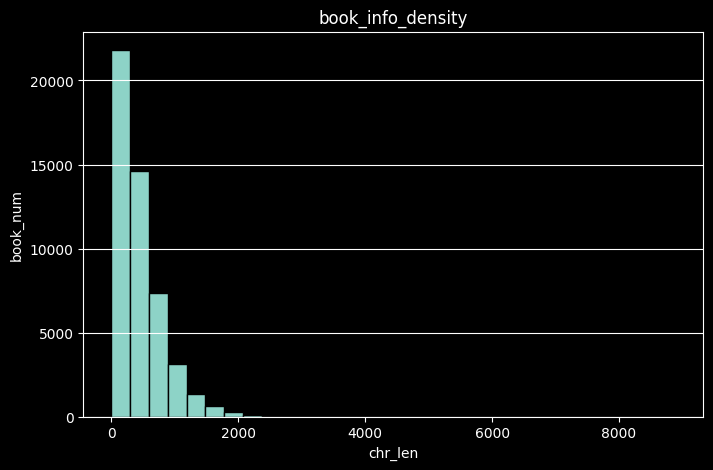

268


In [95]:
import matplotlib.pyplot as plt

df["book_info_char_count"] = df["책소개"].apply(
    lambda x: len(str(x)) if pd.notna(x) else 0
)

plt.figure(figsize=(8, 5))
plt.hist(df["book_info_char_count"], bins=30, edgecolor="black")
plt.title("book_info_density")
plt.xlabel("chr_len")
plt.ylabel("book_num")
plt.grid(axis="y")
plt.show()
print(df[df["book_info_char_count"] > 2000].shape[0])

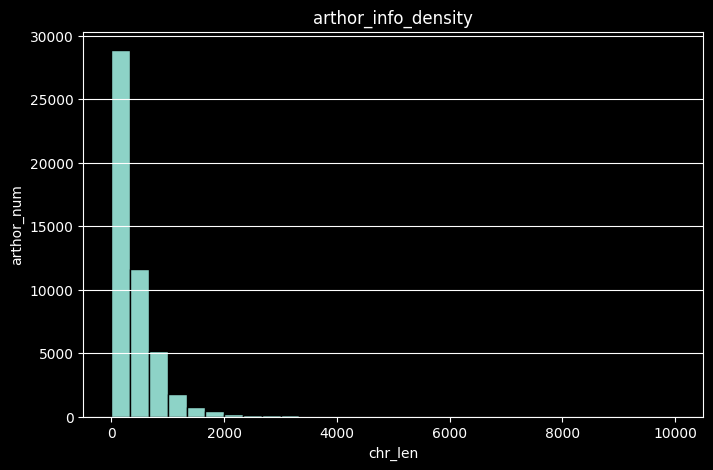

13640


In [105]:
df["arthor_info_char_count"] = df["저자소개"].apply(
    lambda x: len(str(x)) if pd.notna(x) else 0
)


plt.figure(figsize=(8, 5))
plt.hist(df["arthor_info_char_count"].dropna(), bins=30, edgecolor="black")
plt.title("arthor_info_density")
plt.xlabel("chr_len")
plt.ylabel("arthor_num")
plt.grid(axis="y")
plt.show()
print(df[df["arthor_info_char_count"] > 500].shape[0])

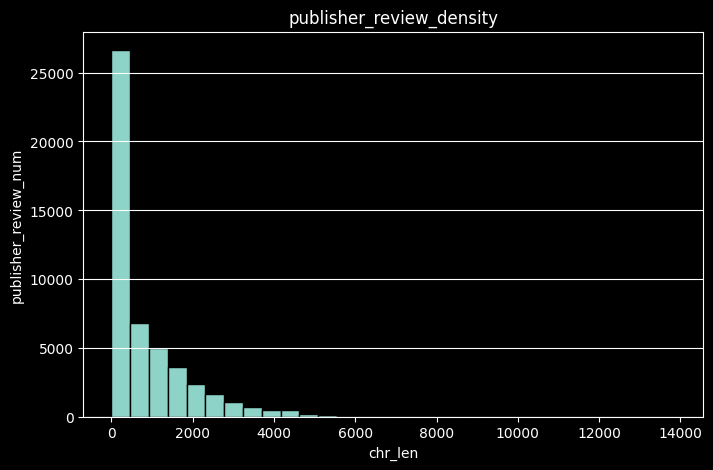

6380


In [ ]:
df["publisher_review_char_count"] = df["출판사리뷰"].apply(
    lambda x: len(str(x)) if pd.notna(x) else 0
)


plt.figure(figsize=(8, 5))
plt.hist(df["publisher_review_char_count"].dropna(), bins=30, edgecolor="black")
plt.title("publisher_review_density")
plt.xlabel("chr_len")
plt.ylabel("publisher_review_num")
plt.grid(axis="y")
plt.show()
print(df[df["publisher_review_char_count"] > 2000].shape[0])

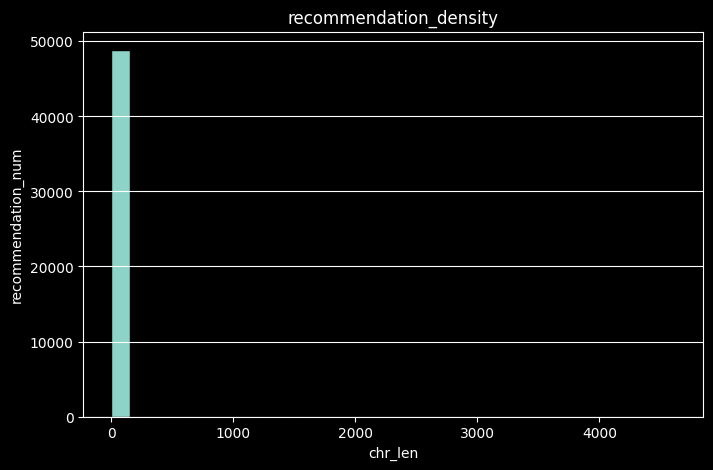

25


In [ ]:
df["recommendation_char_count"] = df["추천사"].apply(
    lambda x: len(str(x)) if pd.notna(x) else 0
)


plt.figure(figsize=(8, 5))
plt.hist(df["recommendation_char_count"].dropna(), bins=30, edgecolor="black")
plt.title("recommendation_density")
plt.xlabel("chr_len")
plt.ylabel("recommendation_num")
plt.grid(axis="y")
plt.show()
print(df[df["recommendation_char_count"] > 2000].shape[0])

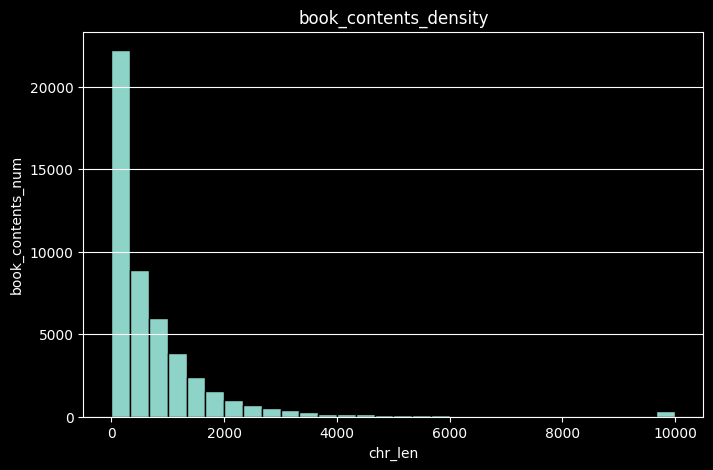

4436


In [ ]:
df["book_contents_char_count"] = df["목차"].apply(
    lambda x: len(str(x)) if pd.notna(x) else 0
)


plt.figure(figsize=(8, 5))
plt.hist(df["book_contents_char_count"].dropna(), bins=30, edgecolor="black")
plt.title("book_contents_density")
plt.xlabel("chr_len")
plt.ylabel("book_contents_num")
plt.grid(axis="y")
plt.show()
print(df[df["book_contents_char_count"] > 2000].shape[0])

In [24]:
df.describe()

,Unnamed: 0,ISBN,페이지,가격,book_info_char_count,arthor_info_char_count,publisher_review_char_count,recommendation_char_count,book_contents_char_count
count,49340.000000,4.934000e+04,49340.000000,49340.000000,49340.000000,49340.000000,49340.000000,49340.000000,49340.000000
mean,24877.532813,9.790525e+12,320.283766,23148.908188,442.092825,381.821990,815.481577,8.389887,818.412789
std,14386.374785,1.004030e+09,326.937973,31070.165112,383.687546,554.468741,1169.532414,105.850005,1304.171684
min,0.000000,9.788900e+12,0.000000,1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12402.750000,9.788984e+12,168.000000,12000.000000,166.000000,19.000000,0.000000,0.000000,117.000000
50%,24878.500000,9.791159e+12,256.000000,16000.000000,341.000000,243.000000,352.000000,0.000000,413.000000
75%,37330.250000,9.791187e+12,376.000000,24000.000000,609.000000,536.000000,1239.000000,0.000000,992.000000
max,49826.000000,9.791199e+12,20160.000000,980000.000000,8885.000000,10000.000000,13872.000000,4620.000000,10000.000000


In [9]:
import requests
import uuid

# Clova Studio Tokenizer API 설정
# C:\Kill_the_RAG\Project\Aiffel_final_project\.env 여기 경로에 있는 NCP_CLOVASTUDIO_API_KEY 이걸로 API키만 받아와서 아래 코드 알맞게게 작성

# API 키 불러오기
API_KEY = os.getenv("NCP_CLOVASTUDIO_API_KEY")  # .env 파일에 저장된 API 키

MODEL_NAME = "LK-D2"  # 모델명 확인
url = f"https://clovastudio.apigw.ntruss.com/testapp/v1/api-tools/tokenize/{MODEL_NAME}"

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json",
    "X-NCP-CLOVASTUDIO-REQUEST-ID": str(uuid.uuid4()),
}

payload = {"text": df["책소개"][20751]}  # 20751번 텍스트 선택

response = requests.post(url, headers=headers, json=payload)

# 결과 출력
print("URL:", url)
print("STATUS:", response.status_code)
print("RESPONSE:", response.text)

URL: https://clovastudio.apigw.ntruss.com/testapp/v1/api-tools/tokenize/LK-D2
STATUS: 200
RESPONSE: {"status":{"code":"20000","message":"OK"},"result":{"numTokens":872}}


### CLOVAX

In [ ]:
# import os
# import json
# import requests
# import uuid
# from dotenv import load_dotenv
# from langchain_community.chat_models import ChatClovaX

# # .env 파일 로드 및 환경변수 설정
# load_dotenv()

# # 아래 두 줄만 사용
# os.environ["NCP_CLOVASTUDIO_API_KEY"] = os.getenv("NCP_CLOVASTUDIO_API_KEY")
# os.environ["NCP_CLOVASTUDIO_API_URL"] = os.getenv("NCP_CLOVASTUDIO_API_URL", "https://clovastudio.stream.ntruss.com/")

# API_KEY = os.environ["NCP_CLOVASTUDIO_API_KEY"]

# # === 토크나이저 설정 ===
# MODEL_NAME = "LK-D2"  # 토크나이저 모델명
# TOKENIZER_URL = f"https://clovastudio.apigw.ntruss.com/testapp/v1/api-tools/tokenize/{MODEL_NAME}"

# # 공통 헤더
# headers = {
#     "Authorization": f"Bearer {API_KEY}",
#     "Content-Type": "application/json",
#     "X-NCP-CLOVASTUDIO-REQUEST-ID": str(uuid.uuid4()),
# }

# # Clova 토크나이저 API를 사용한 토큰 계산 함수
# def calculate_tokens(text):
#     payload = {"text": text}
#     response = requests.post(TOKENIZER_URL, headers=headers, json=payload)
#     if response.status_code == 200:
#         tokens = response.json().get("result", {}).get("numTokens", 0)
#         return tokens
#     else:
#         print("Error calculating tokens:", response.text)
#         return 0

# # 챗 API 호출 클래스 (챗 엔드포인트도 testapp 경로 사용)
# class ChatClovaX:
#     def __init__(self, model, max_tokens):
#         self.model = model
#         self.max_tokens = max_tokens
#         self.chat_url = f"https://clovastudio.apigw.ntruss.com/testapp/v1/api-tools/chat/completions/{model}"

#     def invoke(self, messages, seed=42):
#         payload = {
#             "messages": messages,
#             "max_tokens": self.max_tokens,
#             "seed": seed
#         }
#         response = requests.post(self.chat_url, headers=headers, json=payload)
#         if response.status_code == 200:
#             response_json = response.json()
#             content = response_json.get("choices", [{}])[0].get("message", {}).get("content", "")
#             return type("Response", (), {"content": content})
#         else:
#             raise Exception(f"Chat API 호출 실패 {response.status_code}: {response.text}")

# # Chain-of-Density (COD) 요약 함수 - Clova 토크나이저와 챗 API 사용
# def chain_of_density(text, iterations=5, max_retry=3):
#     total_tokens = 0
#     original_text = text
#     current_text = text
#     results = []

#     # 챗 모델 호출 (여기서는 "HCX-003" 사용; 최신 문서 확인 필요)
#     llm_clova = ChatClovaX(model="HCX-003", max_tokens=2048)

#     for i in range(1, iterations + 1):
#         tokens_used = calculate_tokens(current_text)
#         total_tokens += tokens_used

#         prompt = f"""
#         You are performing a step-by-step Chain-of-Density summarization task.

#         You will follow these two steps based on the following information:

#         ---
#         **Original Article (do NOT rewrite this):**
#         {original_text}

#         **Current Summary (iteration {i}):**
#         {current_text}
#         ---

#         **Step 1:** Identify 1-3 informative entities that appear in the original article but are missing from the current summary. Output them as a semicolon-separated string.

#         **Step 2:** Write a new, denser summary that includes all information from the current summary and the missing entities. The new summary must be the **same length** as the current summary (±5%). You may compress, fuse, or remove uninformative parts to make space.

#         A missing entity is:

#         - relevant to the main story,
#         - specific yet concise (100 words or fewer),
#         - novel (not in the previous summary),
#         - faithful (present in the article),
#         - anywhere (can be located anywhere in the article).

#         Guidelines:
#         - The first summary should be long (8-10 sentences, ~200 words) yet highly non-specific, containing little information beyond the entities marked as missing. Use overly verbose language and fillers (e.g., "this article discusses") to reach ~200 words.
#         - Make every word count: rewrite the previous summary to improve flow and make space for additional entities.
#         - Make space with fusion, compression, and removal of uninformative phrases like "the article discusses".
#         - The summaries should become highly dense and concise yet self-contained, i.e., easily understood without the article.
#         - Missing entities can appear anywhere in the new summary.
#         - Never drop entities from the previous summary. If space cannot be made, add fewer new entities.
#         - Use the same number of words (±5%) as the current summary.
#         - Use only KOREAN language to reply.

#         Return the result as a **single JSON object** in the following format:
#         ```json
#         {{
#           "Missing_Entities": "entity1; entity2; entity3",
#           "Denser_Summary": "your updated summary here in Korean with all listed entities included"
#         }}
#         ```
#         """
#         messages = [
#             {"role": "system", "content": "You are a summarization expert."},
#             {"role": "user", "content": prompt},
#         ]

#         response = llm_clova.invoke(messages)
#         result_text = response.content.strip().replace("```json", "").replace("```", "").strip()

#         try:
#             parsed = json.loads(result_text)
#             print(f"\n=== Iteration {i} ===")
#             print(f"Tokens used: {tokens_used}")
#             print(f"Missing Entities: {parsed['Missing_Entities']}")
#             print(f"Denser Summary:\n{parsed['Denser_Summary']}\n")
#             current_text = parsed["Denser_Summary"]
#             results.append(parsed)
#         except Exception as e:
#             print(f"JSON parsing error at iteration {i}: {e}")

#     print(f"\nTotal tokens used after {iterations} iterations: {total_tokens}")
#     return current_text, total_tokens

# # 초기 test text (예: df['책소개'][20751]가 유효한 텍스트라고 가정)
# initial_text = df['책소개'][20751]
# summaries, total_token_count = chain_of_density(initial_text, iterations=5)
# final_summary = summaries[-1]["Denser_Summary"]
# print("\n[최종 요약 결과]")
# print(final_summary)

### OPENAI_GPT

In [ ]:
import os
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tiktoken
from dotenv import load_dotenv
from openai import OpenAI
from tqdm import tqdm

# API 설정
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
MODEL_NAME = "gpt-4o"

# 출판사리뷰 글자수 컬럼 생성
df["publisher_review_char_count"] = df["출판사리뷰"].apply(
    lambda x: len(str(x)) if pd.notna(x) else 0
)

# 2000자 이상 필터링
filtered = df[df["publisher_review_char_count"] >= 2000][
    ["ISBN", "출판사리뷰"]
].reset_index(drop=True)


# 토큰 계산기
def calculate_tokens(text, model=MODEL_NAME):
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))


# Chain of Density 함수
def chain_of_density(text, iterations=5, max_retry=3):
    total_tokens = 0
    original_text = text
    current_summary = text

    for i in range(1, iterations + 1):
        tokens_used = calculate_tokens(current_summary)
        total_tokens += tokens_used

        prompt = f"""
        You are performing a step-by-step Chain-of-Density summarization task.

        Each iteration requires you to:

        ---

        **Original Article (do NOT rewrite this):**  
        {original_text}

        **Current Summary (iteration {i}):**  
        {current_summary}

        ---

        ## Instructions:

        **Step 1: Identify Missing Entities**  
        Compare the Original Article and the Current Summary.  
        Identify **1-3 informative entities** (separated by semicolons) that:
        - Are present in the Original Article,
        - Are NOT yet included in the Current Summary,
        - Are **noun phrases only** (1 to 4 words max)
        - Are relevant, specific, faithful, and concise (under 100 words each).

        **Step 2: Create a Denser Summary**  
        Using the Current Summary and the Missing Entities:
        - Write a **new summary** of the **same length** (±5%) as the Current Summary,
        - Add all new entities into this summary **explicitly** and **clearly**,
        - Do **not remove** any previously included information,
        - You may compress, fuse, or rephrase to make space,
        - You MUST include all Missing Entities clearly in the summary.

        ---

        ## Hard Constraints:
        - Do NOT hallucinate: only use content from the Original Article.
        - Do NOT drop or skip previously included content.
        - If a Missing Entity is listed but not found in the summary, your answer is INVALID.
        - Each Missing Entity MUST be **clearly stated** in the new summary.

        ---

        ## Summary Guidelines:
        - The first summary should be long (8-10 sentences, ~200 words) and deliberately verbose,
        - Each iteration should become **denser** and more **informative**,
        - Summaries should be self-contained and understandable without the original article.

        ---

        ## Output Format (JSON only, Korean):
        ```json
        {{
        "Missing_Entities": "entity1; entity2; entity3",
        "Denser_Summary": "your updated summary here in Korean with all listed entities included"
        }}
        """
        messages = [
            {"role": "system", "content": "You are a summarization expert."},
            {"role": "user", "content": prompt.strip()},
        ]

        # API 호출 + 재시도
        retry = 0
        while retry < max_retry:
            try:
                response = client.chat.completions.create(
                    model=MODEL_NAME,
                    messages=messages,
                    temperature=0.7,
                )
                content = response.choices[0].message.content.strip()
                result_json = json.loads(content)
                current_summary = result_json["Denser_Summary"]
                break
            except Exception as e:
                retry += 1
                print(f"[Retry {retry}/{max_retry}] Error: {e}")
                time.sleep(2**retry)
                if retry >= max_retry:
                    return None
    return current_summary

In [ ]:
# 결과저장
summaries = []

# 경로
save_path = (
    r"C:\Kill_the_RAG\Project\Aiffel_final_project\Code\Data\summary_publisher.csv"
)

for idx, row in tqdm(filtered.iterrows(), total=len(filtered)):
    review_text = str(row["출판사리뷰"])
    summary = chain_of_density(review_text, iterations=5)
    summaries.append(summary)

    # 100개마다 저장
    if (idx + 1) % 100 == 0 or (idx + 1) == len(filtered):
        filtered.loc[:idx, "summary"] = summaries
        filtered.to_csv(save_path, index=False, encoding="utf-8-sig")
        print(f"[INFO] {idx+1}개 저장 완료: {save_path}")

In [ ]:
df["책소개"][20751]

'이 책을 읽은 분들이 노인 진료에서 작은 기적을 경험하기를 기대하며 이 책은 노인의학 전문의들이 실제 어떻게 노인환자를 평가하고 치료하고 관리하는지를 잘 설명하고 있습니다. 특히, 증례로 시작해서 문제를 제기하고 내용 구성에 맞게 증례의 경과와 실제 관리방법을 제시하고 마지막에 치료(관리) 결과를 증례에 제시함으로써 노인의학적 지식이 실제 어떻게 구현되는지를 보여줌으로써 한층 이해를 높이고 있습니다. 주변에 노인의학 관련 책들이 많이 나와 있지만, 많은 경우 노인에 흔한 질환들을 중심으로 구성된 것들이 많아서 노인의학 정신을 배우기는 쉽지 않습니다. 노인의학이란 노인의 질병에 초점을 맞추는 것과 더불어 각 노인 개인의 특성, 삶의 질을 고려해야하는 학문이기 때문입니다. 그런데 이 책은 바로 노인의학의 철학이 무엇인지, 노인의학이 왜 단순히 내과학문의 연장선이 아닌지를 잘 보여주고 있습니다. 특히, 이 책에서는 질병으로 분리되지 않지만 노인에 흔하고 중요한 문제인 여러 노인증후군(노쇠, 낙상, 거동장애, 실금, 섬망, 인지기능 저하)에 대해 자세히 기술함으로써 다른 의학서적에서는 배우기 어려운 노인의학 핵심을 잘 다루고 있습니다. 이러한 노인증후군은 일반의사들이 잘 진단하지 못하고 잘 관리하지 못하는 문제이며, 흔히 ‘나이가 들어서 그런 것’이라고 치부해버리고 관리를 포기하는 경우가 많은데, 이들 노인증후군을 어떻게 관리하는가에 따라 환자의 기능과 예후가 크게 달라지게 됩니다. 물론 이 책에서 약물 부작용, 치매의 행동정신증상(BPSD), 뇌졸중, 우울증, 심방세동, 수축기 고혈압, 심부전, 골관절염 등과 같이 노인에서 흔한 임상문제에 대해서도 다루고 있어서 임상의로서는 매우 반갑고 유익합니다. 그리고 노인환자를 만나게 되는 다양한 환경, 즉, 급성기 병원, 외래진료, 요양시설, 그리고 재활시설에서 어떻게 노인환자를 평가하고 다학제 팀을 구성하며, 환자를 관리하는지를 상황별로 제시하고 있어서 노인진료의 넓은 스펙트럼을 잘 소개하고 있습니다. 마지막으로 이 책에